<a href="https://colab.research.google.com/github/marco-siino/Enhanced-Home-Appliance-Scheduling-with-GPT/blob/main/Codestral/Codestral_Energy_Cost_Optimization_Nov2014_MSiino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download model and libraries.

Installing dependencies.

In [1]:
!pip install huggingface_hub
!pip install datasets
!pip install py7zr
!pip install gdown

from datasets import load_dataset
from datetime import datetime, timedelta
from huggingface_hub import hf_hub_download
import py7zr
from py7zr import unpack_7zarchive
import matplotlib.pyplot as plt
import json
import re
import datasets
import random
import time
import numpy as np
import tqdm.notebook as tqdm
import tensorflow as tf
import os
import requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "L

Connect to Codestral API

In [3]:
!pip install mistralai
from mistralai import Mistral

#api_key = os.environ['7yOu0lH5XcZC1U2ZUI2uv0ghBDduhHp5']

client = Mistral(api_key='7yOu0lH5XcZC1U2ZUI2uv0ghBDduhHp5')

model = "codestral-latest"

message = [
    {
        "role": "user",
        "content": "Write a function for fibonacci"
    }
]

chat_response = client.chat.complete(
    model=model,
    messages=message
)
print(chat_response.choices[0].message.content)

Sure! Below is a Python function to compute the Fibonacci sequence. The Fibonacci sequence is a series of numbers where each number is the sum of the two preceding ones, usually starting with 0 and 1.

Here are two common ways to implement the Fibonacci function:

1. **Recursive Approach**:
   This is a straightforward but not very efficient approach due to its exponential time complexity.

```python
def fibonacci_recursive(n):
    if n <= 0:
        return 0
    elif n == 1:
        return 1
    else:
        return fibonacci_recursive(n-1) + fibonacci_recursive(n-2)

# Example usage:
print(fibonacci_recursive(10))  # Output: 55
```

2. **Iterative Approach**:
   This approach is more efficient with a linear time complexity.

```python
def fibonacci_iterative(n):
    if n <= 0:
        return 0
    elif n == 1:
        return 1

    a, b = 0, 1
    for _ in range(2, n + 1):
        a, b = b, a + b
    return b

# Example usage:
print(fibonacci_iterative(10))  # Output: 55
```

3. **Me

# Get the dataset.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DNE (Doesn't Need to be Executed) - Dataset structure.
Each CSV file corresponds to a House. For each house there are always 9 appliances. The corresponding description of each appliance is reported below.

House 1

0.Aggregate, 1.Fridge, 2.Chest Freezer, 3.Upright Freezer, 4.Tumble Dryer,
5.Washing Machine, 6.Dishwasher, 7.Computer Site, 8.Television Site, 9.Electric Heater
	!NOTES
		0. October 2014, numerous light bulbs changed to LEDs.
		7.a Desktop Computer
		7.b Computer Monitor

House 2

0.Aggregate, 1.Fridge-Freezer, 2.Washing Machine, 3.Dishwasher, 4.Television,
5.Microwave, 6.Toaster, 7.Hi-Fi, 8.Kettle, 9.Oven Extractor Fan
	!NOTES

House 3

0.Aggregate, 1.Toaster, 2.Fridge-Freezer, 3.Freezer, 4.Tumble Dryer,
5.Dishwasher, 6.Washing Machine, 7.Television, 8.Microwave, 9.Kettle
	!NOTES

House 4

0.Aggregate, 1.Fridge, 2.Freezer, 3.Fridge-Freezer, 4.Washing Machine (1),
5.Washing Machine (2), 6.Computer Site, 7.Television Site, 8.Microwave, 9.Kettle
	!NOTES
		6.a Desktop Computer
		6.b Computer Monitor
		6.c Scanner
		6.d Printer
		6.e Router
		6. Change in signature 01/02/2015
		7.a Television
		7.b DVD Player
		7.c VHS Player
		7. Change in signature 19/12/2014

House 5

0.Aggregate, 1.Fridge-Freezer, 2.Tumble Dryer 3.Washing Machine, 4.Dishwasher,
5.Computer Site, 6.Television Site, 7.Combination Microwave, 8.Kettle, 9.Toaster
	!NOTES
		2. Dehumidifier added on 21/11/2014
		5.a Desktop Computer
		5.b Computer Monitor
		5.c Printer
		5.d Speakers
		5. Change in signature 27/01/2015
		6.a Television w/DVD Player
		6.b Set-top Box
		6.c Games Console

House 6

0.Aggregate, 1.Freezer (Utility Room), 2.Washing Machine, 3.Dishwasher, 4.MJY Computer,
5.Television Site, 6.Microwave, 7.Kettle, 8.Toaster, 9.PGM Computer
	!NOTES
		4.a Desktop Computer
		4.b Computer Monitor
		4.c Computer Monitor
		4.d Printer
		5.a Television
		5.b Set-top Box
		5.c PC
		5.d DVD Player
		9.a Desktop Computer
		9.b Computer Monitor
		9.c Printer
		9.d Shredder

House 7

0.Aggregate, 1.Fridge, 2.Freezer (Garage), 3.Freezer, 4.Tumble Dryer,
5.Washing Machine, 6.Dishwasher, 7.Television Site, 8.Toaster, 9.Kettle
	!NOTES
		3. Change in signature 24/11/13
		6. Change in signature 20/05/14
		7.a Television
		7.b Speakers
		7.c Telephone

House 8

0.Aggregate, 1.Fridge, 2.Freezer, 3.Dryer, 4.Washing Machine,
5.Toaster, 6.Computer, 7.Television Site, 8.Microwave, 9.Kettle
	!NOTES
		1. Change in Fridge Nov 6th
		5.a Toaster
		5.b DAB Radio
		7.a Television
		7.b DVD Player
		7.c VHS Player
		7.d Sound Bar

House 9

0.Aggregate, 1.Fridge-Freezer, 2.Washer Dryer, 3.Washing Machine, 4.Dishwasher,
5.Television Site, 6.Microwave, 7.Kettle, 8.Hi-Fi, 9.Electric Heater
	!NOTES
		5.a Television
		5.b Sky Box
		5.c DVD Player

House 10

0.Aggregate, 1.Magimix (Blender), 2.Freezer, 3.Chest Freezer (In Garage), 4.Fridge-Freezer,
5.Washing Machine, 6.Dishwasher, 7.Television Site, 8.Microwave, 9. Kenwood KMix
	!NOTES
		1. Changed from Fridge to Blender on 17/06/2014
		2. Changed from Freezer to Toaster on 25/06/2014.
		3. Post April 2015, included a second Freezer (both located in Garage)
		4. Changed from Whirlpool ART 500-9/G/1 to AEG SKZ71800F0 March 2015 (Both Fridge-Freezer)
		7.a. TV
		7.b. DVD Player
		7.c. Set-top Box
		7.d. Router
		7.e. Network storage External power supply
		7.f. Laptop external power supply

House 11

0.Aggregate, 1.Fridge, 2.Fridge-Freezer, 3.Washing Machine, 4.Dishwasher,
5.Computer Site, 6.Microwave, 7.Kettle, 8.Router, 9.Hi-Fi
	!NOTES
		0. Aggregate is affected by Solar Panels.
		4. Possible dishwasher replacement

House 12

0.Aggregate, 1.Fridge-Freezer, 2.Television Site(Lounge), 3.Microwave, 4.Kettle,
5.Toaster, 6.Television Site(Bedroom), 7.Not Used, 8.Not Used, 9.Not Used
	!NOTES

House 13

0.Aggregate, 1.Television Site, 2.Unknown, 3.Washing Machine, 4.Dishwasher,
5.Tumble Dryer, 6.Television Site, 7.Computer Site, 8.Microwave, 9.Kettle
	!NOTES
		1.a Television
		1.b Xbox
		1.c Wii
		2. Has a device attached which was not recorded.
		5. Signature changes with no mention of devices attached.
		6.a Television
		6.b Computer
		6.c Current Cost
		7.a Laptop Dock
		7.b Camera System (July-Aug 2014)

House 15

0.Aggregate, 1.Fridge-Freezer, 2.Tumble Dryer, 3.Washing Machine, 4.Dishwasher,
5.Computer Site, 6.Television Site, 7.Microwave, 8.Kettle , 9.Toaster
	!NOTES
		5.a Desktop Computer
		5.b Printer
		6.a Television
		6.b Xbox
		6.c Set-top Box

House 16

0.Aggregate, 1.Fridge-Freezer (1), 2.Fridge-Freezer (2), 3.Electric Heater (1)?,
4.Electric Heater (2), 5.Washing Machine, 6.Dishwasher, 7.Computer Site,
8.Television Site, 9.Dehumidifier/Heater
	!NOTES
		8.a Television
		8.b DVD/Blue-ray Player
		8.c Wii
		8.d Speakers

House 17

0.Aggregate, 1.Freezer (Garage), 2.Fridge-Freezer, 3.Tumble Dryer (Garage), 4.Washing Machine,
5.Computer Site, 6.Television Site, 7.Microwave, 8.Kettle, 9.Plug Site (Bedroom)
	!NOTES
		1. Was replaced 1 month before recording stopped with smaller capacity Freezer.
		2. Was replaced mid May 2015.
		5.a Desktop
		5.b Computer Monitor
		5.c Computer Monitor
		5.d Printer
		8.a Kettle
		8.b Toaster & Misc (Occasionally plugged in)
		9.a Television
		9.b Laptop
		9.c Hair Dryer
		9.d Phone Charger

House 18

0.Aggregate, 1.Fridge(garage), 2.Freezer(garage), 3.Fridge-Freezer,
4.Washer Dryer(garage), 5.Washing Machine, 6.Dishwasher, 7.Desktop Computer,
8.Television Site, 9.Microwave
	!NOTES
		8.a Television
		8.b DVD Player
		8.c Sky Box
		8.d Speakers
		8.e Lamp
		8.f HiFi

House 19

0.Aggregate, 1.Fridge & Freezer, 2.Washing Machine, 3.Television Site, 4.Microwave,
5.Kettle, 6.Toaster, 7.Bread-maker, 8.Lamp (80Watts), 9.Hi-Fi
	!NOTES
		1. This plug has a fridge AND a freezer attached on the same IAM
		3.a Television
		3.b DVD Player

House 20

0.Aggregate, 1.Fridge, 2.Freezer, 3.Tumble Dryer, 4.Washing Machine, 5.Dishwasher,
6.Computer Site, 7.Television Site, 8.Microwave, 9.Kettle
	!NOTES

House 21

0.Aggregate, 1.Fridge-Freezer, 2.Tumble Dryer, 3.Washing Machine,
4.Dishwasher, 5.Food Mixer, 6.Television, 7.Kettle/Toaster, 8.Vivarium, 9.Pond Pump
	!NOTES
		House 21 Aggregate is affected by Solar Panels.

# Make a dictionary for House 1. (Ex. Key-Value -> Fridge-Appliance1)

In [5]:
appliances = [
    "Fridge", "Chest Freezer", "Upright Freezer", "Tumble Dryer",
    "Washing Machine", "Dishwasher", "Computer Site", "Television Site",
    "Electric Heater"
]

appliances_dict = {f"Appliance{i+1}": appliance for i, appliance in enumerate(appliances)}


In [6]:
print(appliances_dict)

{'Appliance1': 'Fridge', 'Appliance2': 'Chest Freezer', 'Appliance3': 'Upright Freezer', 'Appliance4': 'Tumble Dryer', 'Appliance5': 'Washing Machine', 'Appliance6': 'Dishwasher', 'Appliance7': 'Computer Site', 'Appliance8': 'Television Site', 'Appliance9': 'Electric Heater'}


# Make the dataframe from the dataset.

In [7]:
import pandas as pd

def read_csv_to_dataframe(csv_file):
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(csv_file)
    return df

# Example usage:
dataframe = read_csv_to_dataframe("/content/drive/MyDrive/Academic/2025/Journal/GPT Cost Optmization @ Sensors/dataset/House_1.csv")
print(dataframe)


                        Time        Unix  Aggregate  Appliance1  Appliance2  \
0        2013-10-09 13:06:17  1381323977        523          74           0   
1        2013-10-09 13:06:31  1381323991        526          75           0   
2        2013-10-09 13:06:46  1381324006        540          74           0   
3        2013-10-09 13:07:01  1381324021        532          74           0   
4        2013-10-09 13:07:15  1381324035        540          74           0   
...                      ...         ...        ...         ...         ...   
6960003  2015-07-10 11:56:05  1436529365        187           0          45   
6960004  2015-07-10 11:56:12  1436529372        185           0          45   
6960005  2015-07-10 11:56:18  1436529378        181           0          45   
6960006  2015-07-10 11:56:25  1436529385        186           0          45   
6960007  2015-07-10 11:56:32  1436529392        182           0          45   

         Appliance3  Appliance4  Appliance5  Applia

# DNE - With the next cell it is possible to see the working load of a fridge. The pattern is quite regular.

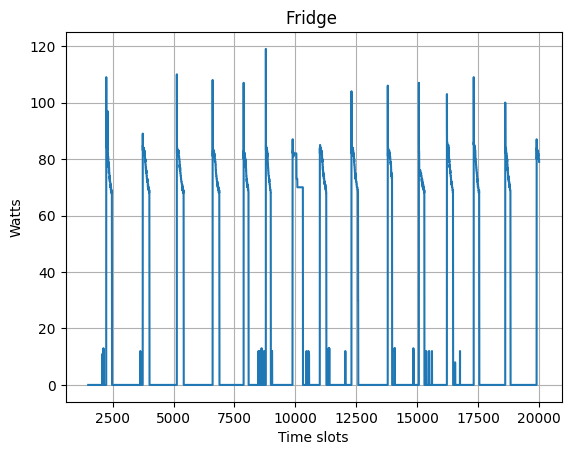

In [ ]:
import matplotlib.pyplot as plt

# Plot all the values in 'Column1'
dataframe['Appliance1'][1500:20000].plot()

# Add labels and title
plt.xlabel('Time slots')
plt.ylabel('Watts')
plt.title('Fridge ')
plt.grid("True")

# Show the plot
plt.show()

# Store the average consumptions of each appliance in the house.

In [8]:
def calculate_avg_appliance_consumption(appliance):

  # Find the maximum and minimum non-zero values
  max_non_zero = dataframe[appliance][dataframe[appliance] != 0].max()
  min_non_zero = dataframe[appliance][dataframe[appliance] != 0].min()

  # Filter the DataFrame to include only values between the maximum and minimum
  filtered_values = dataframe[(dataframe[appliance] > min_non_zero) & (dataframe[appliance] < max_non_zero)][appliance]

  # Calculate the average of the filtered values
  average_between_non_zero = filtered_values.mean()

  return average_between_non_zero

In [9]:
# Save the average consumption of any device in a list.
avg_appliances_consumptions = {}

for i in range(1, len(appliances_dict)+1):
  avg_appliances_consumptions[appliances_dict["Appliance"+str(i)]]=calculate_avg_appliance_consumption("Appliance"+str(i))
  #avg_appliances_consumptions.append((appliances_dict["Appliance"+str(i)],calculate_avg_appliance_consumption("Appliance"+str(i))))

print(avg_appliances_consumptions)


{'Fridge': np.float64(75.79845793092484), 'Chest Freezer': np.float64(48.08923243274837), 'Upright Freezer': np.float64(72.21469605959662), 'Tumble Dryer': np.float64(472.6271729522687), 'Washing Machine': np.float64(513.3838271002094), 'Dishwasher': np.float64(1379.0888017181703), 'Computer Site': np.float64(29.738480373322528), 'Television Site': np.float64(31.700847769012388), 'Electric Heater': np.float64(1007.2853867493128)}


# Sostituisco ora tutti i valori in watts presenti con ON e OFF.

In [10]:
discretized_dataframe = dataframe
for i in range(1,len(appliances_dict)+1):
  discretized_dataframe["Appliance"+str(i)] = np.where(dataframe["Appliance"+str(i)] != 0, 'ON', 'OFF')

In [11]:
print(discretized_dataframe)

                        Time        Unix  Aggregate Appliance1 Appliance2  \
0        2013-10-09 13:06:17  1381323977        523         ON        OFF   
1        2013-10-09 13:06:31  1381323991        526         ON        OFF   
2        2013-10-09 13:06:46  1381324006        540         ON        OFF   
3        2013-10-09 13:07:01  1381324021        532         ON        OFF   
4        2013-10-09 13:07:15  1381324035        540         ON        OFF   
...                      ...         ...        ...        ...        ...   
6960003  2015-07-10 11:56:05  1436529365        187        OFF         ON   
6960004  2015-07-10 11:56:12  1436529372        185        OFF         ON   
6960005  2015-07-10 11:56:18  1436529378        181        OFF         ON   
6960006  2015-07-10 11:56:25  1436529385        186        OFF         ON   
6960007  2015-07-10 11:56:32  1436529392        182        OFF         ON   

        Appliance3 Appliance4 Appliance5 Appliance6 Appliance7 Appliance8  

# La cella seguente contiene la funzione che riceve in input il giorno e l'appliance e in output restituisce tutti gli intervalli di funzionamento, ovvero orari (inizio e fine) di ON.

In [12]:
def get_daily_appliance_operating_times(df,day,appliance):
  df['timestamp'] = pd.to_datetime(df['Time'])
  day_to_filter = day

  # Parse the input date string into a datetime object
  date_obj = datetime.strptime(day, '%Y-%m-%d')
  # Get the day of the week (e.g., "Monday")
  day_of_week = date_obj.strftime('%A')  # Return the day name directly

  # Filter rows related to the specific day
  filtered_df = df[df['timestamp'].dt.date == pd.to_datetime(day_to_filter).date()]
  filtered_df.reset_index(drop=True, inplace=True)

  if filtered_df.empty:
    prompt= "The day you have selected is not in the dataset."

  else:
    # Now manage the case of the appliance either ON or OFF all day long.
    if (filtered_df[appliance] == 'ON').all():
      # Case of an appliance always ON during the current day.
      prompt += "From: 00:00:00 To: 23:59:59\n"+"\n***\n\n"
      return prompt
    if (filtered_df[appliance] == 'OFF').all():
      # Case of an appliance always OFF during the current day.
      prompt = "During the day: " +day+" ("+ day_of_week+"), the "+appliances_dict[appliance] +" was never ON.\n"+"\n***\n\n"
      return prompt

    prompt = "During the day: " +day+" ("+ day_of_week+"), the "+appliances_dict[appliance] +" was ON at these times:\n"

    closed_interval = True

    # Iterate over the DataFrame
    for i in range(0, len(filtered_df)):
      if i==0:
        if filtered_df[appliance][i] == 'ON':
          #The appliance is ON since the day before.
          prompt += "From: 00:00:00 "
          closed_interval = False
        continue

      if filtered_df[appliance][i - 1] == 'ON' and filtered_df[appliance][i] == 'OFF':
        prompt += "To: "+ datetime.strptime(filtered_df.loc[i,'Time'], '%Y-%m-%d %H:%M:%S').strftime('%H:%M:%S') + "\n"
        closed_interval = True
        continue

      if filtered_df[appliance][i - 1] == 'OFF' and filtered_df[appliance][i] == 'ON':
        prompt += "From: "+ datetime.strptime(filtered_df.loc[i,'Time'], '%Y-%m-%d %H:%M:%S').strftime('%H:%M:%S') + " "
        closed_interval = False
        continue

    if closed_interval==False:
      prompt += "To: 23:59:59\n"

  prompt +="\n***\n\n"

  return prompt

In [13]:
print(get_daily_appliance_operating_times(dataframe,'2013-11-18','Appliance1'))

During the day: 2013-11-18 (Monday), the Fridge was ON at these times:
From: 00:00:00 To: 00:03:05
From: 01:46:08 To: 02:16:06
From: 04:07:06 To: 04:37:35
From: 06:35:37 To: 07:06:06
From: 07:17:22 To: 07:17:40
From: 07:21:35 To: 07:21:53
From: 07:23:19 To: 07:23:39
From: 07:47:05 To: 07:47:20
From: 08:29:22 To: 08:30:35
From: 08:47:43 To: 09:07:06
From: 11:04:19 To: 11:34:19
From: 12:10:50 To: 12:11:06
From: 13:19:35 To: 13:19:51
From: 13:34:06 To: 14:05:12
From: 16:05:20 To: 16:37:19
From: 16:44:54 To: 16:45:09
From: 16:45:35 To: 16:45:54
From: 18:29:10 To: 19:03:06
From: 19:05:38 To: 19:06:20
From: 19:32:35 To: 19:33:06
From: 19:34:19 To: 19:34:38
From: 19:37:35 To: 19:38:06
From: 20:10:35 To: 20:11:08
From: 20:12:35 To: 20:13:35
From: 20:17:06 To: 20:46:19
From: 22:28:40 To: 22:59:06

***




# Grazie al prossimo blocco di celle calcolo il costo totale per un giorno.

In [14]:
# La funzione in questa cella conta quante frazioni di ora ci sono in un intervallo di costo.
def count_hours_in_range(interval_start, interval_end, range_start, range_end):
    original_is = interval_start
    original_ie = interval_end
    original_rs = range_start
    original_re = range_end

    interval_start = datetime.strptime(interval_start, "%H:%M:%S")
    interval_end = datetime.strptime(interval_end, "%H:%M:%S")
    range_start = datetime.strptime(range_start, "%H:%M:%S")
    range_end = datetime.strptime(range_end, "%H:%M:%S")

    # SPECIAL CASE: the interval crosses the midnight (00:00:00) of two consecutive days, apply the following if:
    if interval_start > interval_end:
      # Il problema va scomposto...Bisogna dividere l'intervallo in due (A e B). Ovvero quello prima (A) e quello dopo la mezzanotte (B).

      # Conto le ore nel primo e nel secondo intervallo all'interno del medesimo range:
      hours_in_A = count_hours_in_range(original_is,"23:59:59",original_rs,original_re)
      hours_in_B = count_hours_in_range("00:00:00",original_ie,original_rs,original_re)

      return(hours_in_A+hours_in_B)

    # Here all the conditions for an interval that doesnt cross two days.
    # If the entire interval falls within the range
    if range_start <= interval_start and interval_end <= range_end:
        return (interval_end - interval_start).total_seconds() / 3600  # Convert seconds to hours
    # If the interval completely covers the range
    elif interval_start <= range_start and interval_end >= range_end:
        return (range_end - range_start).total_seconds() / 3600  # Convert seconds to hours
    # If the interval and the range partially overlap
    elif interval_start <= range_end and interval_end >= range_start:
        start = max(interval_start, range_start)
        end = min(interval_end, range_end)
        return (end - start).total_seconds() / 3600  # Convert seconds to hours
    # If there is no overlap
    else:
        return 0

# Example usage:
interval_start = "23:00:00"
interval_end = "09:40:00"
range_start = "19:00:00"
range_end = "23:59:59"

hours_counted = count_hours_in_range(interval_start, interval_end, range_start, range_end)
print("Hours counted within the range:", hours_counted)

Hours counted within the range: 0.9997222222222222


In [15]:
f1_cost= 0.07138
f23_cost= 0.06999

# La funzione riceve in input tutti gli intervalli e stampa il costo del singolo intervallo oltre a quello finale.
def calculate_daily_cost(input_string,day,appliance):
    global avg_appliances_consumptions
    total_cost = 0
    lines = input_string.split('\n')
    for line in lines:
        # Define the regular expression pattern to match words in the format xx:xx:xx
        pattern = r'\b\d{2}:\d{2}:\d{2}\b'

        # Find all occurrences of the pattern in the input string
        matches = re.findall(pattern, line)

        # Extract the first and second occurrences
        from_time = matches[0] if matches else None
        to_time = matches[1] if len(matches) > 1 else None

        try:
          if (from_time != None)  and (to_time!=None):

            # Count the hours in the range 00:00:00 - 08:00:00.
            first_range = count_hours_in_range(from_time,to_time,"00:00:00","08:00:00")

            # Count the hours in the range 08:00:00 - 19:00:00.
            second_range = count_hours_in_range(from_time,to_time,"08:00:00","19:00:00")

            # Count the hours in the range 19:00:00 - 23:59:00.
            third_range = count_hours_in_range(from_time,to_time,"19:00:00","23:59:59")

            # Avg consumption expressed in kw.
            avg_appliance_cons_norm = avg_appliances_consumptions[appliances_dict[appliance]]/1000

            # Parse the input date string into a datetime object
            date_obj = datetime.strptime(day, '%Y-%m-%d')
            # Get the day of the week (0: Monday, 1: Tuesday, ..., 6: Sunday)
            day_of_week = date_obj.weekday() + 1  # Adding 1 to start from 1 instead of 0

            if day_of_week != 6 and day_of_week != 7:
              print("From Monday to Friday")
              print("f1 cost: ", f1_cost)
              print("f23 cost: ", f23_cost)
              interval_cost = ((first_range*f23_cost*avg_appliance_cons_norm)+
              (second_range*f1_cost*avg_appliance_cons_norm)+
              (third_range*f23_cost*avg_appliance_cons_norm))
            else:
              print("Saturday or Sunday")
              print("f23 cost: ", f23_cost)
              interval_cost = ((first_range*f23_cost*avg_appliance_cons_norm)+
              (second_range*f23_cost*avg_appliance_cons_norm)+
              (third_range*f23_cost*avg_appliance_cons_norm))

            print("avg_appliance_consumption in watts: ",avg_appliances_consumptions[appliances_dict[appliance]])
            print("First range hours: ",first_range)
            print("Second range hours: ",second_range)
            print("Third range hours: ",third_range)

            total_cost+=interval_cost

            print("Interval cost:", from_time, "To:", to_time, " is equal to:", interval_cost,"\n")
        except:
          continue
    print("Total daily cost for the appliance:", total_cost)
    return total_cost

In [16]:
day = '2014-01-20'
appliance = 'Appliance1'
operating_times = get_daily_appliance_operating_times(discretized_dataframe,day,appliance)
calculate_daily_cost(operating_times,day,appliance)

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  0.41638888888888886
Second range hours:  0
Third range hours:  0
Interval cost: 01:12:17 To: 01:37:16  is equal to: 0.002208998881057655 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  0.41638888888888886
Second range hours:  0
Third range hours:  0
Interval cost: 03:18:47 To: 03:43:46  is equal to: 0.002208998881057655 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  0.4127777777777778
Second range hours:  0
Third range hours:  0
Interval cost: 05:32:29 To: 05:57:15  is equal to: 0.00218984145246943 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  0.0038888888888888888
Second range hours:  0
Thir

np.float64(0.02622816056334317)

In [17]:
def calculate_daily_cost_more_appliances(input_string,day):
  # Se trovo il nome di un appliance setto appliance, taglio agli asterischi e chiamo funzione per app singola.
  split_string = input_string.split("***")
  total_cost = 0
  # It's likely that no appliances have been used this day.
  if len(split_string)<3:
    print("\n* * * * *\nThe total daily cost for all the appliances considered is:", total_cost,"\n")
    return total_cost
  for i in range(4,7):
    appliance = 'Appliance'+str(i)
    print('\n***\n\nStarting with '+appliances_dict[appliance])
    total_cost += calculate_daily_cost(split_string[i-4],day,appliance)

  print("\n* * * * *\nThe total daily cost for all the appliances considered is:", total_cost,"\n")
  return total_cost

In [18]:
def calculate_operating_times_multiple_apps(day):
  operating_times =''
  # From Tumble Dryer (4) to Washdisher (6).
  for i in range(4,7):
    appliance = 'Appliance'+str(i)
    operating_times += get_daily_appliance_operating_times(discretized_dataframe,day,appliance)
  return operating_times

In [19]:
operating_times = calculate_operating_times_multiple_apps('2014-01-20')
print(operating_times)

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***




In [20]:
operating_times = calculate_operating_times_multiple_apps('2013-10-26')
print(operating_times)

During the day: 2013-10-26 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2013-10-26 (Saturday), the Washing Machine was ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***




# DNE - Few-shot prompt per interagire con Mistral. (First working)

In [ ]:
# Funziona bene da 2014-01-01 a 2014-01-05. Poi no.
request = """
Propose a new scheduling to reduce electricity cost. Shift the appliance usage intervals within the most expensive slot (F1) INTRADAY (within the same day).
Do not remove any interval.
Do not change the duration of the intervals.
Do not shift intervals already in the cheapest slots.
Do not propose to use more appliances at the same time.
Avoid explanations.
"""

# Nuovi tentativi.
#request = """
#Shift the appliance usage intervals INTRADAY (within the same day) to reduce electricity cost. DO NOT SHIFT INTERVALS ALREADY IN THE CHEAPEST SLOT.
#DO NOT CHANGE THE DURATION AND THE NUMBER OF THE INTERVALS, DO NOT PROPOSE TO USE MORE APPLIANCES AT THE SAME TIME. AVOID EXPLANATIONS.
#"""

prompt = """
<s>[INST]
The time slots to calculate electricity costs of an appliance are as follows:

F1 slot (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 slot (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

"""+request+"""

ANSWER: [/INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

[INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2013-10-26 (Saturday), the Washing Machine was ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

"""+request+"""

ANSWER: [/INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2013-10-26 (Saturday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher it is better to be ON at these times:
From: 18:09:18 To: 18:09:28

[INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2013-10-29 (Tuesday), the Washing Machine was ON at these times:
From: 10:55:27 To: 11:37:00
From: 11:51:47 To: 11:51:59
From: 12:07:40 To: 12:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher was ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

***

"""+request+"""

ANSWER: [/INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2013-10-29 (Tuesday), the Washing Machine it is better to be ON at these times:
From: 04:55:27 To: 05:37:00
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher it is better to be ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

</s>

  """

# Function to get the Codestral proposal.

In [21]:
def get_codestral_proposal(operating_times,day):
  global prompt
  local_prompt = prompt

  local_prompt+="""
[INST]
"""+calculate_operating_times_multiple_apps(day)+request+"""

ANSWER: [/INST]
"""
  message = [
                    {
                        "role": "user",
                        "content": local_prompt
                    }
                ]

  success = False
  while not success:
                    try:
                        chat_response = client.chat.complete(
                            model=model,
                            messages=message
                        )
                        success = True  # Se non viene sollevata alcuna eccezione, imposta success su True
                    except Exception as e:
                        print(f"Errore: {e}. Riprovo tra 20 secondi...")
                        time.sleep(20)  # Attendi 20 secondi prima di ritentare


  result = chat_response.choices[0].message.content
  print(result+"\n\n")
  #print(response)
  return result

In [22]:
def one_day_simulation(day):
  operating_times = calculate_operating_times_multiple_apps(day)
  print(operating_times)
  # Calcolo e stampo il costo di un giorno X.
  actual_cost = calculate_daily_cost_more_appliances(operating_times,day)

  # Calcolo e stampo il costo del giorno X con la proposta Codestral.
  codestral_operating_times = get_codestral_proposal(operating_times,day)
  print(codestral_operating_times)
  codestral_cost = calculate_daily_cost_more_appliances(codestral_operating_times,day)

# DNE - Prove Simulazione per singoli giorni.

In [ ]:
day = '2013-10-28'
one_day_simulation(day)

During the day: 2013-10-28 (Monday), the Tumble Dryer was ON at these times:
From: 08:12:28 To: 08:19:28

***

During the day: 2013-10-28 (Monday), the Washing Machine was ON at these times:
From: 13:30:02 To: 14:03:29

***

During the day: 2013-10-28 (Monday), the Dishwasher was never ON.

***



***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.11666666666666667
Third range hours:  0
Interval cost: 08:12:28 To: 08:19:28  is equal to: 0.00393588155395551 

Total daily cost for the appliance: 0.00393588155395551

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0.5575
Third range hours:  0
Interval cost: 13:30:02 To: 14:03:29  is equal to: 0.020429775699965215 

Total daily cost for the appliance: 0.0204297

In [ ]:
day = '2013-10-31'
one_day_simulation(day)

During the day: 2013-10-31 (Thursday), the Tumble Dryer was never ON.

***

During the day: 2013-10-31 (Thursday), the Washing Machine was ON at these times:
From: 13:39:31 To: 14:13:02

***

During the day: 2013-10-31 (Thursday), the Dishwasher was ON at these times:
From: 04:29:14 To: 05:07:16
From: 05:07:47 To: 05:09:44
From: 05:09:59 To: 05:10:15
From: 05:10:28 To: 05:10:44
From: 05:10:58 To: 05:11:13
From: 05:11:17 To: 05:11:27
From: 05:11:30 To: 05:11:59
From: 05:12:28 To: 05:12:32
From: 05:13:13 To: 05:13:15

***



<s>
The time slots to calculate electricity costs of an appliance are as follows:

F1 slot (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 slot (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

[INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46


Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     224.27 ms /   365 runs   (    0.61 ms per token,  1627.48 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   46310.41 ms /   365 runs   (  126.88 ms per token,     7.88 tokens per second)
llama_print_timings:       total time =   48400.73 ms /   366 tokens


during the day: 2013-10-31 (thursday), the tumble dryer was never on.

***

during the day: 2013-10-31 (thursday), the washing machine it is better to be on at these times:
from: 21:39:31 to: 22:13:02

***

during the day: 2013-10-31 (thursday), the dishwasher it is better to be on at these times:
from: 04:29:14 to: 05:07:16
from: 05:07:47 to: 05:09:44
from: 05:09:59 to: 05:10:15
from: 05:10:28 to: 05:10:44
from: 05:10:58 to: 05:11:13
from: 05:11:17 to: 05:11:27
from: 05:11:30 to: 05:11:59
from: 05:12:28 to: 05:12:32
from: 05:13:13 to: 05:13:15

[note: the answer is the same as the given schedule, but with all the intervals shifted to the night hours.]


In [ ]:
day = '2014-01-01'
one_day_simulation(day)

During the day: 2014-01-01 (Wednesday), the Tumble Dryer was never ON.

***

During the day: 2014-01-01 (Wednesday), the Washing Machine was ON at these times:
From: 03:10:47 To: 03:11:00
From: 04:29:29 To: 05:07:14
From: 05:10:32 To: 05:11:01
From: 05:55:59 To: 05:56:14
From: 06:33:45 To: 06:33:47

***

During the day: 2014-01-01 (Wednesday), the Dishwasher was never ON.

***



***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.003611111111111111
Second range hours:  0
Third range hours:  0
Interval cost: 03:10:47 To: 03:11:00  is equal to: 0.0012975348410101874 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.6291666666666667
Second range hours:  0
Third range hours:  0
Interval cost: 04:29:29 To: 05:07:14  

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     168.07 ms /   221 runs   (    0.76 ms per token,  1314.91 tokens per second)
llama_print_timings: prompt eval time =    4076.37 ms /  2103 tokens (    1.94 ms per token,   515.90 tokens per second)
llama_print_timings:        eval time =   29199.46 ms /   220 runs   (  132.72 ms per token,     7.53 tokens per second)
llama_print_timings:       total time =   42732.01 ms /  2323 tokens


during the day: 2014-01-01 (wednesday), the tumble dryer was never on.

***

during the day: 2014-01-01 (wednesday), the washing machine it is better to be on at these times:
from: 19:10:47 to: 19:11:00
from: 20:29:29 to: 21:07:14
from: 21:10:32 to: 21:11:01
from: 21:55:59 to: 21:56:14
from: 22:33:45 to: 22:33:47

***

during the day: 2014-01-01 (wednesday), the dishwasher was never on.

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  0.003611111111111111
Interval cost: 19:10:47 To: 19:11:00  is equal to: 0.0012975348410101874 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  0.6291666666666667
Interval cost: 20:29:29 To: 21

In [ ]:
day = '2014-01-02'
one_day_simulation(day)

During the day: 2014-01-02 (Thursday), the Tumble Dryer was ON at these times:
From: 13:30:02 To: 13:45:29

***

During the day: 2014-01-02 (Thursday), the Washing Machine was ON at these times:
From: 04:10:46 To: 04:44:59
From: 04:46:32 To: 04:46:46
From: 05:31:45 To: 05:31:59
From: 07:04:48 To: 07:04:59
From: 07:08:46 To: 07:09:00
From: 12:23:00 To: 12:57:14

***

During the day: 2014-01-02 (Thursday), the Dishwasher was ON at these times:
From: 02:18:34 To: 02:54:00
From: 02:54:02 To: 02:54:14
From: 02:54:45 To: 02:55:00
From: 02:55:14 To: 02:55:29

***



***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.2575
Third range hours:  0
Interval cost: 13:30:02 To: 13:45:29  is equal to: 0.08687052858373233 

Total daily cost for the appliance: 0.08687052858373233

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     218.06 ms /   368 runs   (    0.59 ms per token,  1687.63 tokens per second)
llama_print_timings: prompt eval time =     747.72 ms /   438 tokens (    1.71 ms per token,   585.78 tokens per second)
llama_print_timings:        eval time =   45686.25 ms /   367 runs   (  124.49 ms per token,     8.03 tokens per second)
llama_print_timings:       total time =   50001.77 ms /   805 tokens


during the day: 2014-01-02 (thursday), the tumble dryer it is better to be on at these times:
from: 23:30:02 to: 23:45:29

***

during the day: 2014-01-02 (thursday), the washing machine it is better to be on at these times:
from: 03:10:46 to: 03:44:59
from: 03:46:32 to: 03:46:46
from: 04:31:45 to: 04:31:59
from: 05:04:48 to: 05:04:59
from: 05:08:46 to: 05:09:00
from: 19:23:00 to: 19:57:14

***

during the day: 2014-01-02 (thursday), the dishwasher it is better to be on at these times:
from: 01:18:34 to: 01:54:00
from: 01:54:02 to: 01:54:14
from: 01:54:45 to: 01:55:00
from: 01:55:14 to: 01:55:29

***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0
Third range hours:  0.2575
Interval cost: 23:30:02 To: 23:45:29  is equal to: 0.0851788777749429 

Total daily cost for the appliance: 0.0851788777749429

***

Starting with Washing Machine
From Monday to 

In [ ]:
day = '2014-01-03'
one_day_simulation(day)

During the day: 2014-01-03 (Friday), the Tumble Dryer was ON at these times:
From: 13:13:14 To: 13:28:45
From: 13:39:14 To: 13:56:17

***

During the day: 2014-01-03 (Friday), the Washing Machine was ON at these times:
From: 04:29:00 To: 05:02:15
From: 05:05:14 To: 05:05:33
From: 07:56:29 To: 07:56:30
From: 20:34:16 To: 20:34:18
From: 20:41:17 To: 20:41:32

***

During the day: 2014-01-03 (Friday), the Dishwasher was never ON.

***



***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.2586111111111111
Third range hours:  0
Interval cost: 13:13:14 To: 13:28:45  is equal to: 0.08724537444601381 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.2841666666666667
Third range hours:  0
Interval cost: 13:39:14 To: 13:56:17  is equal to: 0.0958668

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     148.68 ms /   247 runs   (    0.60 ms per token,  1661.25 tokens per second)
llama_print_timings: prompt eval time =    1456.64 ms /   344 tokens (    4.23 ms per token,   236.16 tokens per second)
llama_print_timings:        eval time =   31146.41 ms /   246 runs   (  126.61 ms per token,     7.90 tokens per second)
llama_print_timings:       total time =   35097.13 ms /   590 tokens


during the day: 2014-01-03 (friday), the tumble dryer it is better to be on at these times:
from: 01:13:14 to: 01:28:45
from: 01:39:14 to: 01:56:17

***

during the day: 2014-01-03 (friday), the washing machine it is better to be on at these times:
from: 18:29:00 to: 19:02:15
from: 19:05:14 to: 19:05:33
from: 23:56:29 to: 23:56:30
from: 23:41:17 to: 23:41:32

***

during the day: 2014-01-03 (friday), the dishwasher was never on.

***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0.2586111111111111
Second range hours:  0
Third range hours:  0
Interval cost: 01:13:14 To: 01:28:45  is equal to: 0.0855464241731088 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0.2841666666666667
Second range hours:  0
Third range hours:  0
Interval cost: 01:39:14 To: 01:56:17  is equal to: 0.0939999913309

In [ ]:
day = '2014-01-04'
one_day_simulation(day)

During the day: 2014-01-04 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2014-01-04 (Saturday), the Washing Machine was ON at these times:
From: 04:25:45 To: 05:00:46
From: 05:03:47 To: 05:03:59
From: 06:31:29 To: 06:31:45
From: 06:35:33 To: 06:35:40
From: 07:55:15 To: 07:55:29

***

During the day: 2014-01-04 (Saturday), the Dishwasher was ON at these times:
From: 01:49:28 To: 02:26:01
From: 02:27:14 To: 02:27:29
From: 17:14:45 To: 17:14:59

***



***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.5836111111111111
Second range hours:  0
Third range hours:  0
Interval cost: 04:25:45 To: 05:00:46  is equal to: 0.20970159238172337 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.0033333333333333335
Second range hours:  0
Third range h

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     172.82 ms /   293 runs   (    0.59 ms per token,  1695.42 tokens per second)
llama_print_timings: prompt eval time =    1047.81 ms /   367 tokens (    2.86 ms per token,   350.26 tokens per second)
llama_print_timings:        eval time =   36825.21 ms /   292 runs   (  126.11 ms per token,     7.93 tokens per second)
llama_print_timings:       total time =   40755.54 ms /   659 tokens


during the day: 2014-01-04 (saturday), the tumble dryer was never on.

***

during the day: 2014-01-04 (saturday), the washing machine it is better to be on at these times:
from: 19:25:45 to: 20:00:46
from: 20:03:47 to: 20:03:59
from: 08:31:29 to: 08:31:45
from: 08:35:33 to: 08:35:40
from: 10:55:15 to: 10:55:29

***

during the day: 2014-01-04 (saturday), the dishwasher it is better to be on at these times:
from: 18:49:28 to: 19:26:01
from: 19:27:14 to: 19:27:29
from: 13:14:45 to: 13:14:59

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  0.5836111111111111
Interval cost: 19:25:45 To: 20:00:46  is equal to: 0.20970159238172337 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third rang

In [ ]:
day = '2014-01-06'
one_day_simulation(day)

During the day: 2014-01-06 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-06 (Monday), the Washing Machine was ON at these times:
From: 22:38:46 To: 22:39:00

***

During the day: 2014-01-06 (Monday), the Dishwasher was ON at these times:
From: 02:29:33 To: 03:07:00
From: 03:07:15 To: 03:08:14
From: 03:08:29 To: 03:09:01
From: 03:09:02 To: 03:09:15

***



***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  0.0038888888888888888
Interval cost: 22:38:46 To: 22:39:00  is equal to: 0.0013973452133955865 

Total daily cost for the appliance: 0.0013973452133955865

***

Starting with Dishwasher
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  1379.0888017181703
First range hours:  0.624166666

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     165.99 ms /   274 runs   (    0.61 ms per token,  1650.71 tokens per second)
llama_print_timings: prompt eval time =    3293.73 ms /  2179 tokens (    1.51 ms per token,   661.56 tokens per second)
llama_print_timings:        eval time =   35120.40 ms /   273 runs   (  128.65 ms per token,     7.77 tokens per second)
llama_print_timings:       total time =   47952.98 ms /  2452 tokens


during the day: 2014-01-06 (monday), the tumble dryer was never on.

***

during the day: 2014-01-06 (monday), the washing machine it is better to be on at these times:
from: 05:38:46 to: 05:39:00

***

during the day: 2014-01-06 (monday), the dishwasher it is better to be on at these times:
from: 02:29:33 to: 03:07:00
from: 03:07:15 to: 03:08:14
from: 03:08:29 to: 03:09:01
from: 03:09:02 to: 03:09:15

[note: the washing machine interval from 22:38:46 to 22:39:00 is already in the cheapest slot, so it does not need to be shifted.]

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.0038888888888888888
Second range hours:  0
Third range hours:  0
Interval cost: 05:38:46 To: 05:39:00  is equal to: 0.0013973452133955865 

Total daily cost for the appliance: 0.0013973452133955865

***

Starting with Di

In [ ]:
day = '2014-01-07'
one_day_simulation(day)

During the day: 2014-01-07 (Tuesday), the Tumble Dryer was ON at these times:
From: 18:19:17 To: 18:19:31
From: 20:44:28 To: 20:46:01

***

During the day: 2014-01-07 (Tuesday), the Washing Machine was ON at these times:
From: 01:40:46 To: 01:40:48
From: 02:36:59 To: 02:37:03
From: 03:18:46 To: 03:18:48
From: 04:34:01 To: 05:09:01
From: 05:12:00 To: 05:12:15
From: 05:24:00 To: 05:24:02
From: 05:59:59 To: 06:00:14
From: 06:19:34 To: 06:19:46
From: 06:51:19 To: 06:51:30
From: 06:59:51 To: 07:00:07
From: 11:49:15 To: 12:22:33
From: 23:45:46 To: 23:46:01

***

During the day: 2014-01-07 (Tuesday), the Dishwasher was never ON.

***



***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.0038888888888888888
Third range hours:  0
Interval cost: 18:19:17 To: 18:19:31  is equal to: 0.0013119605179851698 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.0

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     245.56 ms /   408 runs   (    0.60 ms per token,  1661.52 tokens per second)
llama_print_timings: prompt eval time =    1026.03 ms /   519 tokens (    1.98 ms per token,   505.84 tokens per second)
llama_print_timings:        eval time =   52488.95 ms /   407 runs   (  128.97 ms per token,     7.75 tokens per second)
llama_print_timings:       total time =   57408.28 ms /   926 tokens


during the day: 2014-01-07 (tuesday), the tumble dryer it is better to be on at these times:
from: 00:19:17 to: 00:19:31
from: 02:44:28 to: 02:46:01

***

during the day: 2014-01-07 (tuesday), the washing machine it is better to be on at these times:
from: 03:40:46 to: 03:40:48
from: 04:36:59 to: 04:37:03
from: 05:18:46 to: 05:18:48
from: 06:04:01 to: 06:09:01
from: 06:12:00 to: 06:12:15
from: 06:24:00 to: 06:24:02
from: 06:59:59 to: 07:00:14
from: 07:19:34 to: 07:19:46
from: 08:51:19 to: 08:51:30
from: 22:59:51 to: 23:00:07
from: 23:45:46 to: 00:46:01

***

during the day: 2014-01-07 (tuesday), the dishwasher was never on.

***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0.0038888888888888888
Second range hours:  0
Third range hours:  0
Interval cost: 00:19:17 To: 00:19:31  is equal to: 0.0012864123935805833 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999


# Function to calculate the results for one appliance and one period (week, month etc...).

In [23]:
# The following function returns two dictionaries (i.e., one for the actual costs and one for the mistral proposal's costs)
def start_simulation(interval_start,interval_end,appliance):
  actual_costs={}
  mistral_costs={}

  # Convert the input date strings to datetime objects
  start_date = datetime.strptime(interval_start, '%Y-%m-%d')
  end_date = datetime.strptime(interval_end, '%Y-%m-%d')

  # Define the timedelta to increment the date
  delta = timedelta(days=1)

  # Iterate over the range of dates
  current_date = start_date
  while current_date <= end_date:
    print("\n- - - - - - - ")
    day = current_date.strftime('%Y-%m-%d')
    operating_times = get_daily_appliance_operating_times(discretized_dataframe,day,appliance)
    print(operating_times)
    # Calcolo e stampo il costo di un giorno X.
    #print(calculate_daily_cost(operating_times,appliance,day))
    actual_cost = calculate_daily_cost(operating_times,day,appliance)

    # Calcolo e stampo il costo del giorno X con la proposta Mistral.
    mistral_operating_times = get_mistral_proposal(operating_times,day,appliance)
    print(mistral_operating_times)
    mistral_cost = calculate_daily_cost(mistral_operating_times,day,appliance)

    actual_costs[day]=actual_cost
    mistral_costs[day]=mistral_cost

    # Define the directory path
    folder_name = appliances_dict[appliance]
    file_name = appliances_dict[appliance]+"_"+day+".txt"
    directory_path = os.path.join(os.getcwd(), folder_name)

    # Create the directory if it doesn't exist
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # Define the file path
    file_path = os.path.join(directory_path, file_name)

    with open(file_path, 'w') as f:
      # Write some content to the file
      f.write("\n- - - - - - -\n ")
      f.write(str(operating_times)+"\n")
      f.write("The total actual daily cost is:"+str(actual_cost)+"\n")
      f.write("Mistral operating times:\n"+str(mistral_operating_times)+"\n")
      f.write("The total Mistral daily cost is:"+str(mistral_cost)+"\n")
      f.write("Saved: "+str(actual_cost-mistral_cost))

    # Move to the next date
    current_date += delta

  return actual_costs,mistral_costs

# Function to calculate the results for more appliances and one period (week, month etc...).

In [24]:
# The following function returns two dictionaries (i.e., one for the actual costs and one for the mistral proposal's costs)
def start_simulation_more_appliances(interval_start,interval_end):
  actual_costs={}
  codestral_costs={}

  # Convert the input date strings to datetime objects
  start_date = datetime.strptime(interval_start, '%Y-%m-%d')
  end_date = datetime.strptime(interval_end, '%Y-%m-%d')

  # Define the timedelta to increment the date
  delta = timedelta(days=1)

  # Iterate over the range of dates
  current_date = start_date
  while current_date <= end_date:
    print("\n- - - - - - - \n")
    day = current_date.strftime('%Y-%m-%d')
    operating_times = calculate_operating_times_multiple_apps(day)
    print(operating_times)
    # Calcolo e stampo il costo di un giorno X.
    #print(calculate_daily_cost(operating_times,appliance,day))
    actual_cost = calculate_daily_cost_more_appliances(operating_times,day)

    # Calcolo e stampo il costo del giorno X con la proposta Codestral.
    codestral_operating_times = get_codestral_proposal(operating_times,day)
    print(codestral_operating_times)
    codestral_cost = calculate_daily_cost_more_appliances(codestral_operating_times,day)

    actual_costs[day]=actual_cost
    codestral_costs[day]=codestral_cost

    # Define the directory path
    folder_name = 'multiple_appliances'
    file_name = 'multiple_appliances'+"_"+day+".txt"
    directory_path = os.path.join(os.getcwd(), folder_name)

    # Create the directory if it doesn't exist
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # Define the file path
    file_path = os.path.join(directory_path, file_name)

    with open(file_path, 'w') as f:
      # Write some content to the file
      f.write("\n- - - - - - -\n ")
      f.write(str(operating_times)+"\n")
      f.write("The total actual daily cost is:"+str(actual_cost)+"\n")
      f.write("Codestral operating times:\n"+str(codestral_operating_times)+"\n")
      f.write("The total Codestral daily cost is:"+str(codestral_cost)+"\n")
      f.write("Saved: "+str(actual_cost-codestral_cost))

    # Move to the next date
    current_date += delta

  return actual_costs,codestral_costs

# Simulations for a full period with 3 appliances.

## Experimental prompt #1

In [ ]:
# Funziona bene da 2014-01-01 a 2014-01-05. Poi no.
request = """
Propose a new scheduling to reduce electricity cost. Shift the appliance usage intervals falling within the most expensive slot (F1).
Shift only INTRADAY (within the same day).
Do not delete appliance usage intervals.
Do not change the duration of the appliances usage time slots.
Do not shift intervals already in the cheapest slots.
Do not propose to use more appliances at the same time.
Avoid explanations.
"""

# Nuovi tentativi.
#request = """
#Shift the appliance usage intervals INTRADAY (within the same day) to reduce electricity cost. DO NOT SHIFT INTERVALS ALREADY IN THE CHEAPEST SLOT.
#DO NOT CHANGE THE DURATION AND THE NUMBER OF THE INTERVALS, DO NOT PROPOSE TO USE MORE APPLIANCES AT THE SAME TIME. AVOID EXPLANATIONS.
#"""

prompt = """
<s>[INST]
The daily rates to calculate electricity costs of an appliance are as follows:

F1 rate (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 rate (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

Propose a new scheduling to reduce electricity cost. Shift the appliance usage intervals falling within the most expensive slot (F1).
Shift only INTRADAY (within the same day).
Do not delete appliance usage intervals.
Do not change the duration of the appliances usage time slots.
Do not shift intervals already in the cheapest slots.
Do not propose to use more appliances at the same time.
Avoid explanations.

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

ANSWER: [/INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

[INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2013-10-26 (Saturday), the Washing Machine was ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

ANSWER: [/INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2013-10-26 (Saturday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher it is better to be ON at these times:
From: 18:09:18 To: 18:09:28

[INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2013-10-29 (Tuesday), the Washing Machine was ON at these times:
From: 10:55:27 To: 11:37:00
From: 11:51:47 To: 11:51:59
From: 12:07:40 To: 12:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher was ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

***

ANSWER: [/INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2013-10-29 (Tuesday), the Washing Machine it is better to be ON at these times:
From: 04:55:27 To: 05:37:00
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher it is better to be ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

</s>

  """

In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2014-01-01','2014-01-03')


- - - - - - - 
During the day: 2014-01-01 (Wednesday), the Tumble Dryer was never ON.

***

During the day: 2014-01-01 (Wednesday), the Washing Machine was ON at these times:
From: 03:10:47 To: 03:11:00
From: 04:29:29 To: 05:07:14
From: 05:10:32 To: 05:11:01
From: 05:55:59 To: 05:56:14
From: 06:33:45 To: 06:33:47

***

During the day: 2014-01-01 (Wednesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     236.67 ms /   208 runs   (    1.14 ms per token,   878.88 tokens per second)
llama_print_timings: prompt eval time =    5813.10 ms /  2371 tokens (    2.45 ms per token,   407.87 tokens per second)
llama_print_timings:        eval time =   30774.87 ms /   207 runs   (  148.67 ms per token,     6.73 tokens per second)
llama_print_timings:       total time =   50955.26 ms /  2578 tokens


during the day: 2014-01-01 (wednesday), the washing machine it is better to be on at these times:
from: 19:10:47 to: 20:11:00
from: 20:29:29 to: 21:07:14
from: 21:10:32 to: 21:11:01
from: 21:55:59 to: 21:56:14
from: 22:33:45 to: 22:33:47

***

during the day: 2014-01-01 (wednesday), the dishwasher was never on.

(no change for the dishwasher as it was not used during the most expensive slot)

- - - - - - - 
During the day: 2014-01-02 (Thursday), the Tumble Dryer was ON at these times:
From: 13:30:02 To: 13:45:29

***

During the day: 2014-01-02 (Thursday), the Washing Machine was ON at these times:
From: 04:10:46 To: 04:44:59
From: 04:46:32 To: 04:46:46
From: 05:31:45 To: 05:31:59
From: 07:04:48 To: 07:04:59
From: 07:08:46 To: 07:09:00
From: 12:23:00 To: 12:57:14

***

During the day: 2014-01-02 (Thursday), the Dishwasher was ON at these times:
From: 02:18:34 To: 02:54:00
From: 02:54:02 To: 02:54:14
From: 02:54:45 To: 02:55:00
From: 02:55:14 To: 02:55:29

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     244.34 ms /   345 runs   (    0.71 ms per token,  1411.94 tokens per second)
llama_print_timings: prompt eval time =    1604.72 ms /   458 tokens (    3.50 ms per token,   285.41 tokens per second)
llama_print_timings:        eval time =   48970.04 ms /   344 runs   (  142.35 ms per token,     7.02 tokens per second)
llama_print_timings:       total time =   54748.45 ms /   802 tokens


during the day: 2014-01-02 (thursday), the tumble dryer it is better to be on at these times:
from: 20:30:02 to: 21:45:29

***

during the day: 2014-01-02 (thursday), the washing machine it is better to be on at these times:
from: 04:10:46 to: 04:44:59
from: 04:46:32 to: 04:46:46
from: 05:31:45 to: 05:31:59
from: 07:08:46 to: 07:09:00
from: 19:23:00 to: 19:57:14

***

during the day: 2014-01-02 (thursday), the dishwasher it is better to be on at these times:
from: 02:18:34 to: 02:54:00
from: 02:54:02 to: 02:54:14
from: 02:54:45 to: 02:55:00
from: 02:55:14 to: 02:55:29

- - - - - - - 
During the day: 2014-01-03 (Friday), the Tumble Dryer was ON at these times:
From: 13:13:14 To: 13:28:45
From: 13:39:14 To: 13:56:17

***

During the day: 2014-01-03 (Friday), the Washing Machine was ON at these times:
From: 04:29:00 To: 05:02:15
From: 05:05:14 To: 05:05:33
From: 07:56:29 To: 07:56:30
From: 20:34:16 To: 20:34:18
From: 20:41:17 To: 20:41:32

***

During the day: 2014-01-03 (Friday), the Dis

Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     180.49 ms /   270 runs   (    0.67 ms per token,  1495.95 tokens per second)
llama_print_timings: prompt eval time =     864.54 ms /   364 tokens (    2.38 ms per token,   421.03 tokens per second)
llama_print_timings:        eval time =   35040.25 ms /   269 runs   (  130.26 ms per token,     7.68 tokens per second)
llama_print_timings:       total time =   38799.84 ms /   633 tokens


during the day: 2014-01-03 (friday), the tumble dryer it is better to be on at these times:
from: 19:13:14 to: 20:28:45
from: 20:39:14 to: 20:56:17

***

during the day: 2014-01-03 (friday), the washing machine it is better to be on at these times:
from: 04:29:00 to: 05:02:15
from: 05:05:14 to: 05:05:33
from: 05:07:16 to: 05:38:15
from: 19:34:16 to: 19:34:18
from: 19:41:17 to: 19:41:32

***

during the day: 2014-01-03 (friday), the dishwasher was never on.


## Experimental prompt #2
Re-put the request before the answer.

In [ ]:
# Funziona bene da 2014-01-01 a 2014-01-05. Poi no.
request = """
The daily rates to calculate electricity costs of an appliance are as follows:

F1 rate (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 rate (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

Propose a new scheduling to reduce electricity cost. Shift the appliance usage intervals that are within the most expensive slot (F1).
Shift only INTRADAY (within the same day).
Keep the same appliance usage intervals.
Keep the same duration of the intervals for any interval.
Shift only the intervals in the most expensive slots.
Propose to use only one appliance per time.
Avoid explanations.
"""

# Nuovi tentativi.
#request = """
#Shift the appliance usage intervals INTRADAY (within the same day) to reduce electricity cost. DO NOT SHIFT INTERVALS ALREADY IN THE CHEAPEST SLOT.
#DO NOT CHANGE THE DURATION AND THE NUMBER OF THE INTERVALS, DO NOT PROPOSE TO USE MORE APPLIANCES AT THE SAME TIME. AVOID EXPLANATIONS.
#"""

prompt = """
<s>[INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

"""+request+"""

ANSWER: [/INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

[INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-26 (Saturday), the Washing Machine was ON at these times:
From: 06:33:28 To: 07:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

"""+request+"""

ANSWER: [/INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer it is better to be ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-26 (Saturday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher it is better to be ON at these times:
From: 18:09:18 To: 18:09:28

[INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2013-10-29 (Tuesday), the Washing Machine was ON at these times:
From: 10:55:27 To: 11:37:00
From: 11:51:47 To: 11:51:59
From: 12:07:40 To: 12:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher was ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

***

"""+request+"""

ANSWER: [/INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2013-10-29 (Tuesday), the Washing Machine it is better to be ON at these times:
From: 04:55:27 To: 05:37:00
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher it is better to be ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

</s>

  """

In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-01','2015-06-03')


- - - - - - - 
During the day: 2015-06-01 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-06-01 (Monday), the Washing Machine was ON at these times:
From: 07:21:24 To: 07:54:43

***

During the day: 2015-06-01 (Monday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =      79.34 ms /   117 runs   (    0.68 ms per token,  1474.72 tokens per second)
llama_print_timings: prompt eval time =    2563.91 ms /   312 tokens (    8.22 ms per token,   121.69 tokens per second)
llama_print_timings:        eval time =   14943.23 ms /   116 runs   (  128.82 ms per token,     7.76 tokens per second)
llama_print_timings:       total time =   20143.76 ms /   428 tokens


during the day: 2015-06-01 (monday), the washing machine it is better to be on at these times:
from: 23:21:24 to: 02:54:43

***

[explanation: shifting the washing machine usage interval from 7:21 am to 11:21 pm allows it to be operated during the cheapest rate (f23) instead of the most expensive rate (f1).]

- - - - - - - 
During the day: 2015-06-02 (Tuesday), the Tumble Dryer was ON at these times:
From: 06:00:47 To: 06:01:28

***

During the day: 2015-06-02 (Tuesday), the Washing Machine was ON at these times:
From: 00:12:20 To: 00:12:26
From: 02:51:48 To: 02:51:55
From: 05:30:59 To: 06:04:36
From: 07:03:19 To: 07:03:26

***

During the day: 2015-06-02 (Tuesday), the Dishwasher was ON at these times:
From: 10:31:00 To: 10:31:07
From: 11:49:55 To: 12:30:35
From: 12:30:49 To: 12:31:22
From: 12:31:36 To: 12:31:43
From: 12:31:56 To: 12:32:03

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     240.81 ms /   384 runs   (    0.63 ms per token,  1594.60 tokens per second)
llama_print_timings: prompt eval time =    1182.54 ms /   514 tokens (    2.30 ms per token,   434.66 tokens per second)
llama_print_timings:        eval time =   49604.23 ms /   383 runs   (  129.51 ms per token,     7.72 tokens per second)
llama_print_timings:       total time =   55132.13 ms /   897 tokens


during the day: 2015-06-02 (tuesday), the tumble dryer it is better to be on at these times:
from: 00:00:47 to: 00:01:28

***

during the day: 2015-06-02 (tuesday), the washing machine it is better to be on at these times:
from: 03:51:48 to: 04:21:55
from: 05:30:59 to: 06:04:36
from: 19:03:19 to: 19:03:26

***

during the day: 2015-06-02 (tuesday), the dishwasher it is better to be on at these times:
from: 23:31:00 to: 23:31:07
from: 09:49:55 to: 10:20:35
from: 12:30:49 to: 12:31:22
from: 12:31:36 to: 12:31:43
from: 12:31:56 to: 12:32:03

[note: the new scheduling keeps the same appliance usage intervals but shifts them to be outside of the most expensive slot (f1) whenever possible. in this case, the tumble dryer is shifted to the middle of the night and the washing machine is shifted to early morning.]

- - - - - - - 
During the day: 2015-06-03 (Wednesday), the Tumble Dryer was ON at these times:
From: 05:38:24 To: 05:38:51

***

During the day: 2015-06-03 (Wednesday), the Washing Ma

Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     100.08 ms /   158 runs   (    0.63 ms per token,  1578.67 tokens per second)
llama_print_timings: prompt eval time =    1530.52 ms /   331 tokens (    4.62 ms per token,   216.27 tokens per second)
llama_print_timings:        eval time =   19803.65 ms /   157 runs   (  126.14 ms per token,     7.93 tokens per second)
llama_print_timings:       total time =   23554.36 ms /   488 tokens


during the day: 2015-06-03 (wednesday), the tumble dryer it is better to be on at these times:
from: 20:38:24 to: 20:38:51

***

during the day: 2015-06-03 (wednesday), the washing machine it is better to be on at these times:
from: 09:01:52 to: 09:34:37

***

during the day: 2015-06-03 (wednesday), the dishwasher was never on.


## Experimental prompt #3.

In [ ]:
request = """
Generate new time intervals (keep the same number of intervals and keep the same duration for each interval) to reduce electricity cost.
Shift only the intervals that are within the most expensive rate (F1). Shift only INTRADAY (within the same day).
Use only one appliance per time.
Avoid explanations.
"""


prompt = """
<s>[INST]
The daily rates to calculate electricity costs of an appliance are as follows:

F1 rate (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 rate (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

"""+request+"""

ANSWER: [/INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

[INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-26 (Saturday), the Washing Machine was ON at these times:
From: 06:33:28 To: 07:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

"""+request+"""

ANSWER: [/INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer it is better to be ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-26 (Saturday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher it is better to be ON at these times:
From: 18:09:18 To: 18:09:28

[INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was ON at these times:
From: 15:00:47 To: 15:01:28

***

During the day: 2013-10-29 (Tuesday), the Washing Machine was ON at these times:
From: 10:55:27 To: 11:37:00
From: 11:51:47 To: 11:51:59
From: 12:07:40 To: 12:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher was ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

***

"""+request+"""

ANSWER: [/INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer it is better to be ON at these times:
From: 06:00:47 To: 06:01:28

***

During the day: 2013-10-29 (Tuesday), the Washing Machine it is better to be ON at these times:
From: 04:55:27 To: 05:37:00
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher it is better to be ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

</s>

  """

In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-01','2015-06-03')


- - - - - - - 
During the day: 2015-06-01 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-06-01 (Monday), the Washing Machine was ON at these times:
From: 07:21:24 To: 07:54:43

***

During the day: 2015-06-01 (Monday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =      54.81 ms /    66 runs   (    0.83 ms per token,  1204.07 tokens per second)
llama_print_timings: prompt eval time =    6097.89 ms /  2143 tokens (    2.85 ms per token,   351.43 tokens per second)
llama_print_timings:        eval time =    8592.70 ms /    65 runs   (  132.20 ms per token,     7.56 tokens per second)
llama_print_timings:       total time =   24458.12 ms /  2208 tokens


during the day: 2015-06-01 (monday), the washing machine it is better to be on at these times:
from: 19:21:24 to: 19:54:43

[end of answer]

- - - - - - - 
During the day: 2015-06-02 (Tuesday), the Tumble Dryer was ON at these times:
From: 06:00:47 To: 06:01:28

***

During the day: 2015-06-02 (Tuesday), the Washing Machine was ON at these times:
From: 00:12:20 To: 00:12:26
From: 02:51:48 To: 02:51:55
From: 05:30:59 To: 06:04:36
From: 07:03:19 To: 07:03:26

***

During the day: 2015-06-02 (Tuesday), the Dishwasher was ON at these times:
From: 10:31:00 To: 10:31:07
From: 11:49:55 To: 12:30:35
From: 12:30:49 To: 12:31:22
From: 12:31:36 To: 12:31:43
From: 12:31:56 To: 12:32:03

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     302.67 ms /   437 runs   (    0.69 ms per token,  1443.80 tokens per second)
llama_print_timings: prompt eval time =    2069.40 ms /   407 tokens (    5.08 ms per token,   196.68 tokens per second)
llama_print_timings:        eval time =   56615.48 ms /   436 runs   (  129.85 ms per token,     7.70 tokens per second)
llama_print_timings:       total time =   63388.23 ms /   843 tokens


during the day: 2015-06-02 (tuesday), the tumble dryer it is better to be on at these times:
from: 19:00:47 to: 19:01:28

***

during the day: 2015-06-02 (tuesday), the washing machine it is better to be on at these times:
from: 03:12:20 to: 03:12:26
from: 05:21:48 to: 05:21:55
from: 07:29:59 to: 07:54:36
from: 19:03:19 to: 19:03:26

***

during the day: 2015-06-02 (tuesday), the dishwasher it is better to be on at these times:
from: 08:31:00 to: 08:31:07
from: 10:49:55 to: 11:10:35
from: 11:10:49 to: 11:11:22
from: 11:11:36 to: 11:11:43
from: 11:11:56 to: 11:12:03
from: 11:12:16 to: 11:12:18
from: 11:12:33 to: 11:12:36
from: 11:13:24 to: 11:13:27
from: 11:13:39 to: 11:13:42

- - - - - - - 
During the day: 2015-06-03 (Wednesday), the Tumble Dryer was ON at these times:
From: 05:38:24 To: 05:38:51

***

During the day: 2015-06-03 (Wednesday), the Washing Machine was ON at these times:
From: 09:01:52 To: 09:34:37

***

During the day: 2015-06-03 (Wednesday), the Dishwasher was never ON.


Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =      88.97 ms /   123 runs   (    0.72 ms per token,  1382.50 tokens per second)
llama_print_timings: prompt eval time =    1760.78 ms /   224 tokens (    7.86 ms per token,   127.22 tokens per second)
llama_print_timings:        eval time =   15956.68 ms /   122 runs   (  130.79 ms per token,     7.65 tokens per second)
llama_print_timings:       total time =   19475.43 ms /   346 tokens


during the day: 2015-06-03 (wednesday), the tumble dryer it is better to be on at these times:
from: 19:38:24 to: 19:38:51

***

during the day: 2015-06-03 (wednesday), the washing machine it is better to be on at these times:
from: 13:01:52 to: 13:34:37


## Experimental prompt #4
(Simplified prompt)--> Non malissimo.

In [ ]:
request = """
Generate new time intervals (keep the same number of intervals and keep the same duration for each interval) to reduce electricity cost.
Shift only the intervals that are within the most expensive rate (F1). Shift only INTRADAY (within the same day).
Use only one appliance per time.
Avoid explanations.
"""


prompt = """
<s>[INST]
The daily rates to calculate electricity costs of an appliance are as follows:

F1 rate (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 rate (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

"""+request+"""

[/INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

[INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-26 (Saturday), the Washing Machine was ON at these times:
From: 06:33:28 To: 07:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

"""+request+"""

[/INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer it is better to be ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-26 (Saturday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher it is better to be ON at these times:
From: 18:09:18 To: 18:09:28


</s>

  """

In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-01','2015-06-03')


- - - - - - - 
During the day: 2015-06-01 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-06-01 (Monday), the Washing Machine was ON at these times:
From: 07:21:24 To: 07:54:43

***

During the day: 2015-06-01 (Monday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =      53.80 ms /    59 runs   (    0.91 ms per token,  1096.57 tokens per second)
llama_print_timings: prompt eval time =    3542.93 ms /  1110 tokens (    3.19 ms per token,   313.30 tokens per second)
llama_print_timings:        eval time =    7545.34 ms /    58 runs   (  130.09 ms per token,     7.69 tokens per second)
llama_print_timings:       total time =   16602.14 ms /  1168 tokens


during the day: 2015-06-01 (monday), the washing machine it is better to be on at these times:
from: 19:21:24 to: 20:54:43

- - - - - - - 
During the day: 2015-06-02 (Tuesday), the Tumble Dryer was ON at these times:
From: 06:00:47 To: 06:01:28

***

During the day: 2015-06-02 (Tuesday), the Washing Machine was ON at these times:
From: 00:12:20 To: 00:12:26
From: 02:51:48 To: 02:51:55
From: 05:30:59 To: 06:04:36
From: 07:03:19 To: 07:03:26

***

During the day: 2015-06-02 (Tuesday), the Dishwasher was ON at these times:
From: 10:31:00 To: 10:31:07
From: 11:49:55 To: 12:30:35
From: 12:30:49 To: 12:31:22
From: 12:31:36 To: 12:31:43
From: 12:31:56 To: 12:32:03

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     236.97 ms /   345 runs   (    0.69 ms per token,  1455.86 tokens per second)
llama_print_timings: prompt eval time =    1878.23 ms /   407 tokens (    4.61 ms per token,   216.69 tokens per second)
llama_print_timings:        eval time =   45079.32 ms /   344 runs   (  131.04 ms per token,     7.63 tokens per second)
llama_print_timings:       total time =   51083.80 ms /   751 tokens


during the day: 2015-06-02 (tuesday), the tumble dryer it is better to be on at these times:
from: 06:01:28 to: 06:02:13

***

during the day: 2015-06-02 (tuesday), the washing machine it is better to be on at these times:
from: 04:12:20 to: 04:12:26
from: 03:51:48 to: 04:21:55
from: 07:30:59 to: 08:04:36
from: 19:03:19 to: 19:03:26

***

during the day: 2015-06-02 (tuesday), the dishwasher it is better to be on at these times:
from: 11:31:00 to: 11:31:07
from: 12:49:55 to: 13:20:35
from: 13:20:49 to: 13:21:22
from: 13:21:36 to: 13:21:43
from: 13:21:56 to: 13:22:03

- - - - - - - 
During the day: 2015-06-03 (Wednesday), the Tumble Dryer was ON at these times:
From: 05:38:24 To: 05:38:51

***

During the day: 2015-06-03 (Wednesday), the Washing Machine was ON at these times:
From: 09:01:52 To: 09:34:37

***

During the day: 2015-06-03 (Wednesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     115.85 ms /   160 runs   (    0.72 ms per token,  1381.06 tokens per second)
llama_print_timings: prompt eval time =    1707.16 ms /   224 tokens (    7.62 ms per token,   131.21 tokens per second)
llama_print_timings:        eval time =   21114.22 ms /   159 runs   (  132.79 ms per token,     7.53 tokens per second)
llama_print_timings:       total time =   24694.68 ms /   383 tokens


during the day: 2015-06-03 (wednesday), the tumble dryer it is better to be on at these times:
from: 05:38:24 to: 05:38:51

***

during the day: 2015-06-03 (wednesday), the washing machine it is better to be on at these times:
from: 19:01:52 to: 19:34:37



***

during the day: 2015-06-03 (wednesday), the dishwasher was never on.


## Experimental prompt #5
(Simplified prompt) -> Funziona. Solo output non formattato correttamente in alcuni casi.

In [ ]:
request = """

Generate new time intervals (keep the same number of intervals and keep the same duration for each interval) to reduce electricity cost.
Shift only the intervals that are within the most expensive rate (F1). Shift only INTRADAY (within the same day).
Use only one appliance per time.
Avoid explanations and always output the intervals for all the appliances.

"""


prompt = """
<s>[INST]
The daily rates to calculate electricity costs of an appliance are as follows:

F1 rate (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 rate (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

- - - - -

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

"""+request+"""

[/INST]
- - - - -

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

[INST]
- - - - -

During the day: 2013-10-25 (Friday), the Tumble Dryer was ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-25 (Friday), the Washing Machine was ON at these times:
From: 06:33:28 To: 07:09:44

***

During the day: 2013-10-25 (Friday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

"""+request+"""

[/INST]
- - - - -
During the day: 2013-10-25 (Friday), the Tumble Dryer it is better to be ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-25 (Friday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-25 (Friday), the Dishwasher it is better to be ON at these times:
From: 20:09:18 To: 20:09:28


</s>

  """

In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-05','2015-06-07')


- - - - - - - 
During the day: 2015-06-05 (Friday), the Tumble Dryer was never ON.

***

During the day: 2015-06-05 (Friday), the Washing Machine was never ON.

***

During the day: 2015-06-05 (Friday), the Dishwasher was ON at these times:
From: 12:11:08 To: 12:23:25
From: 12:23:27 To: 12:53:10
From: 12:53:17 To: 12:53:37
From: 12:53:51 To: 12:54:24
From: 12:54:38 To: 12:54:44
From: 12:54:51 To: 12:55:04
From: 12:55:18 To: 12:55:39
From: 12:56:06 To: 12:56:13
From: 19:14:38 To: 19:14:52

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =     207.97 ms /   310 runs   (    0.67 ms per token,  1490.56 tokens per second)
llama_print_timings: prompt eval time =    2448.92 ms /   390 tokens (    6.28 ms per token,   159.25 tokens per second)
llama_print_timings:        eval time =   39232.77 ms /   309 runs   (  126.97 ms per token,     7.88 tokens per second)
llama_print_timings:       total time =   44938.11 ms /   699 tokens


during the day: 2015-06-05 (friday), the tumble dryer was never on.

***

during the day: 2015-06-05 (friday), the washing machine was never on.

***

during the day: 2015-06-05 (friday), the dishwasher it is better to be on at these times:
from: 03:11:08 to: 03:23:25
from: 03:23:27 to: 04:53:10
from: 04:53:17 to: 04:53:37
from: 04:53:51 to: 04:54:24
from: 04:54:38 to: 04:54:44
from: 04:54:51 to: 04:55:04
from: 04:55:18 to: 04:55:39
from: 04:56:06 to: 04:56:13
from: 23:14:38 to: 23:14:52

- - - - - - - 
During the day: 2015-06-06 (Saturday), the Tumble Dryer was ON at these times:
From: 15:49:16 To: 15:56:15

***

During the day: 2015-06-06 (Saturday), the Washing Machine was ON at these times:
From: 09:00:02 To: 09:00:08
From: 09:00:15 To: 09:34:37
From: 09:39:28 To: 10:38:30
From: 10:40:45 To: 11:14:40
From: 11:15:00 To: 11:15:07
From: 11:18:30 To: 11:53:39
From: 15:09:43 To: 15:21:13

***

During the day: 2015-06-06 (Saturday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =     175.61 ms /   303 runs   (    0.58 ms per token,  1725.45 tokens per second)
llama_print_timings: prompt eval time =    1816.82 ms /   369 tokens (    4.92 ms per token,   203.10 tokens per second)
llama_print_timings:        eval time =   38097.12 ms /   302 runs   (  126.15 ms per token,     7.93 tokens per second)
llama_print_timings:       total time =   43018.58 ms /   671 tokens


during the day: 2015-06-06 (saturday), the tumble dryer it is better to be on at these times:
from: 15:49:16 to: 15:56:15

***

during the day: 2015-06-06 (saturday), the washing machine it is better to be on at these times:
from: 03:00:02 to: 03:00:08
from: 03:00:15 to: 03:34:37
from: 03:39:28 to: 14:38:30
from: 14:40:45 to: 15:14:40
from: 15:15:00 to: 15:15:07
from: 15:18:30 to: 15:53:39
from: 23:09:43 to: 23:21:13

***

during the day: 2015-06-06 (saturday), the dishwasher it is better to be on at these times:
n/a

- - - - - - - 
During the day: 2015-06-07 (Sunday), the Tumble Dryer was never ON.

***

During the day: 2015-06-07 (Sunday), the Washing Machine was never ON.

***

During the day: 2015-06-07 (Sunday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      72.86 ms /   116 runs   (    0.63 ms per token,  1592.16 tokens per second)
llama_print_timings: prompt eval time =    1155.68 ms /   184 tokens (    6.28 ms per token,   159.21 tokens per second)
llama_print_timings:        eval time =   14776.03 ms /   115 runs   (  128.49 ms per token,     7.78 tokens per second)
llama_print_timings:       total time =   17193.72 ms /   299 tokens


- - - - -

during the day: 2015-06-07 (sunday), the tumble dryer does not need to be on.

***

during the day: 2015-06-07 (sunday), the washing machine does not need to be on.

***

during the day: 2015-06-07 (sunday), the dishwasher does not need to be on.


In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-08','2015-06-11')


- - - - - - - 
During the day: 2015-06-08 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-06-08 (Monday), the Washing Machine was never ON.

***

During the day: 2015-06-08 (Monday), the Dishwasher was ON at these times:
From: 10:10:53 To: 10:50:53
From: 10:51:00 To: 10:51:13
From: 10:51:20 To: 10:51:27
From: 10:51:41 To: 10:51:47
From: 10:51:54 To: 10:52:14

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      95.24 ms /   152 runs   (    0.63 ms per token,  1595.92 tokens per second)
llama_print_timings: prompt eval time =    1790.67 ms /   301 tokens (    5.95 ms per token,   168.09 tokens per second)
llama_print_timings:        eval time =   18206.23 ms /   151 runs   (  120.57 ms per token,     8.29 tokens per second)
llama_print_timings:       total time =   22080.50 ms /   452 tokens


during the day: 2015-06-08 (monday), the dishwasher it is better to be on at these times:
from: 23:10:53 to: 00:50:53
from: 00:51:00 to: 00:51:13
from: 00:51:20 to: 00:51:27
from: 00:51:41 to: 00:51:47
from: 00:51:54 to: 00:52:14

- - - - - - - 
During the day: 2015-06-09 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2015-06-09 (Tuesday), the Washing Machine was never ON.

***

During the day: 2015-06-09 (Tuesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      71.95 ms /   112 runs   (    0.64 ms per token,  1556.55 tokens per second)
llama_print_timings: prompt eval time =    1639.74 ms /   181 tokens (    9.06 ms per token,   110.38 tokens per second)
llama_print_timings:        eval time =   13631.67 ms /   111 runs   (  122.81 ms per token,     8.14 tokens per second)
llama_print_timings:       total time =   17115.72 ms /   292 tokens


- - - - -
during the day: 2015-06-09 (tuesday), the tumble dryer does not need to be on.

***

during the day: 2015-06-09 (tuesday), the washing machine does not need to be on.

***

during the day: 2015-06-09 (tuesday), the dishwasher does not need to be on.

- - - - - - - 
During the day: 2015-06-10 (Wednesday), the Tumble Dryer was never ON.

***

During the day: 2015-06-10 (Wednesday), the Washing Machine was never ON.

***

During the day: 2015-06-10 (Wednesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      73.99 ms /   116 runs   (    0.64 ms per token,  1567.86 tokens per second)
llama_print_timings: prompt eval time =    1604.40 ms /   185 tokens (    8.67 ms per token,   115.31 tokens per second)
llama_print_timings:        eval time =   14456.08 ms /   115 runs   (  125.71 ms per token,     7.96 tokens per second)
llama_print_timings:       total time =   17451.53 ms /   300 tokens


- - - - -

during the day: 2015-06-10 (wednesday), the tumble dryer does not need to be on.

***

during the day: 2015-06-10 (wednesday), the washing machine does not need to be on.

***

during the day: 2015-06-10 (wednesday), the dishwasher does not need to be on.

- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      56.38 ms /    76 runs   (    0.74 ms per token,  1347.90 tokens per second)
llama_print_timings: prompt eval time =    1533.19 ms /   140 tokens (   10.95 ms per token,    91.31 tokens per second)
llama_print_timings:        eval time =    9446.26 ms /    75 runs   (  125.95 ms per token,     7.94 tokens per second)
llama_print_timings:       total time =   11925.68 ms /   215 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.


In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-12','2015-06-20')


- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      96.22 ms /   120 runs   (    0.80 ms per token,  1247.12 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   15777.86 ms /   120 runs   (  131.48 ms per token,     7.61 tokens per second)
llama_print_timings:       total time =   16569.02 ms /   121 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.

to generate new time intervals, i would need to know the original time intervals for each appliance on that day, so i could shift them accordingly to minimize electricity costs while adhering to the given conditions.

- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      82.51 ms /   120 runs   (    0.69 ms per token,  1454.30 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   15844.28 ms /   120 runs   (  132.04 ms per token,     7.57 tokens per second)
llama_print_timings:       total time =   16539.79 ms /   121 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.

to generate new time intervals, i would need to know the original time intervals for each appliance on that day, so i could shift them accordingly to minimize electricity costs while adhering to the given conditions.

- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      84.98 ms /   120 runs   (    0.71 ms per token,  1412.10 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   16026.92 ms /   120 runs   (  133.56 ms per token,     7.49 tokens per second)
llama_print_timings:       total time =   16723.47 ms /   121 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.

to generate new time intervals, i would need to know the original time intervals for each appliance on that day, so i could shift them accordingly to minimize electricity costs while adhering to the given conditions.

- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      81.76 ms /   120 runs   (    0.68 ms per token,  1467.66 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   15753.81 ms /   120 runs   (  131.28 ms per token,     7.62 tokens per second)
llama_print_timings:       total time =   16458.96 ms /   121 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.

to generate new time intervals, i would need to know the original time intervals for each appliance on that day, so i could shift them accordingly to minimize electricity costs while adhering to the given conditions.

- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      86.99 ms /   120 runs   (    0.72 ms per token,  1379.48 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   15947.75 ms /   120 runs   (  132.90 ms per token,     7.52 tokens per second)
llama_print_timings:       total time =   16638.87 ms /   121 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.

to generate new time intervals, i would need to know the original time intervals for each appliance on that day, so i could shift them accordingly to minimize electricity costs while adhering to the given conditions.

- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      79.76 ms /   120 runs   (    0.66 ms per token,  1504.59 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   15997.78 ms /   120 runs   (  133.31 ms per token,     7.50 tokens per second)
llama_print_timings:       total time =   16633.14 ms /   121 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.

to generate new time intervals, i would need to know the original time intervals for each appliance on that day, so i could shift them accordingly to minimize electricity costs while adhering to the given conditions.

- - - - - - - 
During the day: 2015-06-18 (Thursday), the Tumble Dryer was never ON.

***

During the day: 2015-06-18 (Thursday), the Washing Machine was ON at these times:
From: 01:40:39 To: 01:40:46
From: 05:48:18 To: 05:48:25

***

During the day: 2015-06-18 (Thursday), the Dishwasher was ON at these times:
From: 01:46:19 To: 01:46:25

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      85.31 ms /   141 runs   (    0.61 ms per token,  1652.80 tokens per second)
llama_print_timings: prompt eval time =    1135.18 ms /   269 tokens (    4.22 ms per token,   236.97 tokens per second)
llama_print_timings:        eval time =   17316.39 ms /   140 runs   (  123.69 ms per token,     8.08 tokens per second)
llama_print_timings:       total time =   20077.54 ms /   409 tokens


during the day: 2015-06-18 (thursday), the washing machine it is better to be on at these times:
from: 19:40:39 to: 19:40:46
from: 04:48:18 to: 04:48:25

during the day: 2015-06-18 (thursday), the dishwasher it is better to be on at these times:
from: 19:46:19 to: 19:46:25

- - - - - - - 
During the day: 2015-06-19 (Friday), the Tumble Dryer was ON at these times:
From: 08:28:44 To: 08:28:51

***

During the day: 2015-06-19 (Friday), the Washing Machine was never ON.

***

During the day: 2015-06-19 (Friday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      51.51 ms /    85 runs   (    0.61 ms per token,  1650.29 tokens per second)
llama_print_timings: prompt eval time =     884.44 ms /   206 tokens (    4.29 ms per token,   232.91 tokens per second)
llama_print_timings:        eval time =   10138.52 ms /    84 runs   (  120.70 ms per token,     8.29 tokens per second)
llama_print_timings:       total time =   12084.83 ms /   290 tokens


during the day: 2015-06-19 (friday), the tumble dryer it is better to be on at these times:
from: 19:28:44 to: 19:28:51

(since the washing machine and dishwasher were never on, no intervals need to be generated for them.)

- - - - - - - 
During the day: 2015-06-20 (Saturday), the Tumble Dryer was ON at these times:
From: 06:15:25 To: 06:15:45

***

During the day: 2015-06-20 (Saturday), the Washing Machine was never ON.

***

During the day: 2015-06-20 (Saturday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      51.58 ms /    85 runs   (    0.61 ms per token,  1647.99 tokens per second)
llama_print_timings: prompt eval time =     827.38 ms /   207 tokens (    4.00 ms per token,   250.19 tokens per second)
llama_print_timings:        eval time =   10604.80 ms /    84 runs   (  126.25 ms per token,     7.92 tokens per second)
llama_print_timings:       total time =   12570.60 ms /   291 tokens


during the day: 2015-06-20 (saturday), the tumble dryer it is better to be on at these times:
from: 19:15:25 to: 19:15:45

(since the washing machine and dishwasher were never on, no intervals need to be generated for them.)


In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-20','2015-06-30')


- - - - - - - 
During the day: 2015-06-20 (Saturday), the Tumble Dryer was ON at these times:
From: 06:15:25 To: 06:15:45

***

During the day: 2015-06-20 (Saturday), the Washing Machine was never ON.

***

During the day: 2015-06-20 (Saturday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      54.66 ms /    85 runs   (    0.64 ms per token,  1555.10 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   10891.31 ms /    85 runs   (  128.13 ms per token,     7.80 tokens per second)
llama_print_timings:       total time =   11372.20 ms /    86 tokens


during the day: 2015-06-20 (saturday), the tumble dryer it is better to be on at these times:
from: 19:15:25 to: 19:15:45

(since the washing machine and dishwasher were never on, no intervals need to be generated for them.)

- - - - - - - 
During the day: 2015-06-21 (Sunday), the Tumble Dryer was never ON.

***

During the day: 2015-06-21 (Sunday), the Washing Machine was ON at these times:
From: 05:31:27 To: 05:31:47

***

During the day: 2015-06-21 (Sunday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      44.18 ms /    59 runs   (    0.75 ms per token,  1335.48 tokens per second)
llama_print_timings: prompt eval time =    1635.86 ms /   209 tokens (    7.83 ms per token,   127.76 tokens per second)
llama_print_timings:        eval time =    6308.72 ms /    58 runs   (  108.77 ms per token,     9.19 tokens per second)
llama_print_timings:       total time =    9040.33 ms /   267 tokens


during the day: 2015-06-21 (sunday), the washing machine it is better to be on at these times:
from: 19:31:27 to: 19:31:47

- - - - - - - 
During the day: 2015-06-22 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-06-22 (Monday), the Washing Machine was never ON.

***

During the day: 2015-06-22 (Monday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      78.85 ms /   107 runs   (    0.74 ms per token,  1356.97 tokens per second)
llama_print_timings: prompt eval time =    1527.94 ms /   184 tokens (    8.30 ms per token,   120.42 tokens per second)
llama_print_timings:        eval time =   13743.58 ms /   106 runs   (  129.66 ms per token,     7.71 tokens per second)
llama_print_timings:       total time =   16682.32 ms /   290 tokens


- - - - -

during the day: 2015-06-22 (monday), the tumble dryer is not used.

***

during the day: 2015-06-22 (monday), the washing machine is not used.

***

during the day: 2015-06-22 (monday), the dishwasher is not used.

- - - - - - - 
During the day: 2015-06-23 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2015-06-23 (Tuesday), the Washing Machine was never ON.

***

During the day: 2015-06-23 (Tuesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      68.71 ms /   112 runs   (    0.61 ms per token,  1629.97 tokens per second)
llama_print_timings: prompt eval time =    1517.96 ms /   181 tokens (    8.39 ms per token,   119.24 tokens per second)
llama_print_timings:        eval time =   13691.30 ms /   111 runs   (  123.35 ms per token,     8.11 tokens per second)
llama_print_timings:       total time =   16459.77 ms /   292 tokens


- - - - -
during the day: 2015-06-23 (tuesday), the tumble dryer does not need to be on.

***

during the day: 2015-06-23 (tuesday), the washing machine does not need to be on.

***

during the day: 2015-06-23 (tuesday), the dishwasher does not need to be on.

- - - - - - - 
During the day: 2015-06-24 (Wednesday), the Tumble Dryer was never ON.

***

During the day: 2015-06-24 (Wednesday), the Washing Machine was never ON.

***

During the day: 2015-06-24 (Wednesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      72.25 ms /   107 runs   (    0.68 ms per token,  1480.93 tokens per second)
llama_print_timings: prompt eval time =    1541.31 ms /   184 tokens (    8.38 ms per token,   119.38 tokens per second)
llama_print_timings:        eval time =   13319.78 ms /   106 runs   (  125.66 ms per token,     7.96 tokens per second)
llama_print_timings:       total time =   16130.04 ms /   290 tokens


- - - - -

during the day: 2015-06-24 (wednesday), the tumble dryer is not used.

***

during the day: 2015-06-24 (wednesday), the washing machine is not used.

***

during the day: 2015-06-24 (wednesday), the dishwasher is not used.

- - - - - - - 
During the day: 2015-06-25 (Thursday), the Tumble Dryer was never ON.

***

During the day: 2015-06-25 (Thursday), the Washing Machine was never ON.

***

During the day: 2015-06-25 (Thursday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      68.27 ms /   112 runs   (    0.61 ms per token,  1640.67 tokens per second)
llama_print_timings: prompt eval time =    1523.76 ms /   181 tokens (    8.42 ms per token,   118.79 tokens per second)
llama_print_timings:        eval time =   14290.53 ms /   111 runs   (  128.74 ms per token,     7.77 tokens per second)
llama_print_timings:       total time =   17060.02 ms /   292 tokens


- - - - -
during the day: 2015-06-25 (thursday), the tumble dryer does not need to be on.

***

during the day: 2015-06-25 (thursday), the washing machine does not need to be on.

***

during the day: 2015-06-25 (thursday), the dishwasher does not need to be on.

- - - - - - - 
During the day: 2015-06-26 (Friday), the Tumble Dryer was never ON.

***

During the day: 2015-06-26 (Friday), the Washing Machine was never ON.

***

During the day: 2015-06-26 (Friday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      70.32 ms /   112 runs   (    0.63 ms per token,  1592.67 tokens per second)
llama_print_timings: prompt eval time =    1866.48 ms /   181 tokens (   10.31 ms per token,    96.97 tokens per second)
llama_print_timings:        eval time =   13649.15 ms /   111 runs   (  122.97 ms per token,     8.13 tokens per second)
llama_print_timings:       total time =   16731.20 ms /   292 tokens


- - - - -
during the day: 2015-06-26 (friday), the tumble dryer does not need to be on.

***

during the day: 2015-06-26 (friday), the washing machine does not need to be on.

***

during the day: 2015-06-26 (friday), the dishwasher does not need to be on.

- - - - - - - 
During the day: 2015-06-27 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2015-06-27 (Saturday), the Washing Machine was never ON.

***

During the day: 2015-06-27 (Saturday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      73.16 ms /   112 runs   (    0.65 ms per token,  1530.95 tokens per second)
llama_print_timings: prompt eval time =    1120.88 ms /   181 tokens (    6.19 ms per token,   161.48 tokens per second)
llama_print_timings:        eval time =   13873.30 ms /   111 runs   (  124.98 ms per token,     8.00 tokens per second)
llama_print_timings:       total time =   16260.30 ms /   292 tokens


- - - - -
during the day: 2015-06-27 (saturday), the tumble dryer does not need to be on.

***

during the day: 2015-06-27 (saturday), the washing machine does not need to be on.

***

during the day: 2015-06-27 (saturday), the dishwasher does not need to be on.

- - - - - - - 
During the day: 2015-06-28 (Sunday), the Tumble Dryer was never ON.

***

During the day: 2015-06-28 (Sunday), the Washing Machine was never ON.

***

During the day: 2015-06-28 (Sunday), the Dishwasher was ON at these times:
From: 17:13:55 To: 17:14:02

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      40.63 ms /    60 runs   (    0.68 ms per token,  1476.85 tokens per second)
llama_print_timings: prompt eval time =    1074.13 ms /   209 tokens (    5.14 ms per token,   194.58 tokens per second)
llama_print_timings:        eval time =    7226.90 ms /    59 runs   (  122.49 ms per token,     8.16 tokens per second)
llama_print_timings:       total time =    9316.65 ms /   268 tokens


during the day: 2015-06-28 (sunday), the dishwasher it is better to be on at these times:
from: 03:13:55 to: 03:14:02

- - - - - - - 
During the day: 2015-06-29 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-06-29 (Monday), the Washing Machine was ON at these times:
From: 13:35:02 To: 14:08:42

***

During the day: 2015-06-29 (Monday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      39.60 ms /    59 runs   (    0.67 ms per token,  1489.82 tokens per second)
llama_print_timings: prompt eval time =    1513.39 ms /   209 tokens (    7.24 ms per token,   138.10 tokens per second)
llama_print_timings:        eval time =    7220.22 ms /    58 runs   (  124.49 ms per token,     8.03 tokens per second)
llama_print_timings:       total time =    9730.37 ms /   267 tokens


during the day: 2015-06-29 (monday), the washing machine it is better to be on at these times:
from: 07:35:02 to: 08:08:42

- - - - - - - 
During the day: 2015-06-30 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2015-06-30 (Tuesday), the Washing Machine was ON at these times:
From: 08:51:25 To: 08:51:31
From: 08:52:25 To: 08:52:32
From: 08:52:59 To: 08:53:19
From: 08:54:54 To: 08:55:00
From: 08:55:27 To: 08:55:34
From: 08:56:48 To: 08:57:02
From: 08:58:29 To: 08:58:36
From: 08:59:44 To: 08:59:50
From: 09:01:25 To: 09:01:31
From: 09:03:33 To: 09:03:47
From: 09:04:40 To: 09:04:47
From: 09:06:08 To: 09:39:41
From: 09:42:30 To: 09:42:37
From: 09:54:12 To: 09:54:19
From: 09:55:13 To: 09:55:26
From: 09:55:40 To: 09:55:46
From: 09:56:07 To: 09:56:13
From: 09:58:49 To: 09:58:55
From: 10:02:25 To: 10:02:38
From: 10:03:52 To: 10:38:29
From: 12:47:52 To: 13:21:39
From: 15:39:41 To: 15:39:48
From: 15:41:42 To: 15:41:49
From: 15:42:02 To: 15:42:09
From: 15:46:46 To: 15:46:59
From:

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =     479.88 ms /   770 runs   (    0.62 ms per token,  1604.56 tokens per second)
llama_print_timings: prompt eval time =    3504.27 ms /   897 tokens (    3.91 ms per token,   255.97 tokens per second)
llama_print_timings:        eval time =   98647.43 ms /   769 runs   (  128.28 ms per token,     7.80 tokens per second)
llama_print_timings:       total time =  110816.14 ms /  1666 tokens


during the day: 2015-06-30 (tuesday), the washing machine it is better to be on at these times:
from: 19:51:25 to: 19:51:31
from: 19:52:25 to: 19:52:32
from: 19:52:59 to: 19:53:19
from: 19:54:54 to: 19:55:00
from: 19:55:27 to: 19:55:34
from: 19:56:48 to: 19:56:59
from: 19:58:29 to: 19:58:36
from: 19:59:44 to: 19:59:50
from: 20:01:25 to: 20:01:31
from: 20:03:33 to: 20:03:47
from: 20:04:40 to: 20:04:47
from: 20:06:08 to: 21:39:41
from: 21:42:30 to: 21:42:37
from: 21:54:12 to: 21:54:19
from: 21:55:13 to: 21:55:26
from: 21:55:40 to: 21:55:46
from: 21:56:07 to: 21:56:13
from: 21:58:49 to: 21:58:55
from: 22:02:25 to: 22:02:38
from: 22:03:52 to: 23:38:29
from: 07:47:52 to: 08:21:39
from: 11:39:41 to: 11:39:48
from: 11:41:42 to: 11:41:49
from: 11:42:02 to: 11:42:09
from: 11:46:46 to: 11:46:59
from: 11:49:34 to: 11:49:41
from: 11:49:48 to: 11:49:54
from: 11:50:28 to: 11:50:35
from: 11:53:24 to: 11:53:30
from: 11:55:18 to: 12:31:36
from: 12:33:51 to: 12:34:11

(note that the new intervals are wi

## Experimental Prompt #6.

In [ ]:
request = """

Generate new time intervals (keep the same number of intervals and keep the same duration for each interval) to reduce electricity cost.
Shift only the intervals that are within the most expensive rate (F1). Shift only INTRADAY (within the same day) and if it is necessary.
Use only one appliance per time.
Always format the output in three interval groups (in order: 1. Tumble Dryer, 2. Washing Machine, 3. Dishwasher) separated by ***
Avoid explanations.

"""


prompt = """
<s>[INST]
The daily rates to calculate electricity costs of an appliance are as follows:

F1 rate (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 rate (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

- - - - -

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

"""+request+"""

[/INST]
- - - - -

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

[INST]
- - - - -

During the day: 2013-10-25 (Friday), the Tumble Dryer was ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-25 (Friday), the Washing Machine was ON at these times:
From: 06:33:28 To: 07:09:44

***

During the day: 2013-10-25 (Friday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

"""+request+"""

[/INST]
- - - - -

During the day: 2013-10-25 (Friday), the Tumble Dryer it is better to be ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-25 (Friday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-25 (Friday), the Dishwasher it is better to be ON at these times:
From: 20:09:18 To: 20:09:28

***

[INST]
- - - - -

During the day: 2015-02-03 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2015-02-03 (Tuesday), the Washing Machine was never ON.

***

During the day: 2015-02-03 (Tuesday), the Dishwasher was ON at these times:
From: 12:39:21 To: 13:20:27
From: 13:20:34 To: 13:21:01
From: 13:21:27 To: 13:21:34

***

"""+request+"""

[/INST]
- - - - -

During the day: 2015-02-03 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2015-02-03 (Tuesday), the Washing Machine was never ON.

***

During the day: 2015-02-03 (Tuesday), the Dishwasher it is better to be ON at these times:
From: 20:39:21 To: 20:20:27
From: 21:20:34 To: 21:21:01
From: 21:21:27 To: 21:21:34

***

</s>

  """

### Old results with Prompt #6.

In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-08','2015-06-11')


- - - - - - - 

During the day: 2015-06-08 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-06-08 (Monday), the Washing Machine was never ON.

***

During the day: 2015-06-08 (Monday), the Dishwasher was ON at these times:
From: 10:10:53 To: 10:50:53
From: 10:51:00 To: 10:51:13
From: 10:51:20 To: 10:51:27
From: 10:51:41 To: 10:51:47
From: 10:51:54 To: 10:52:14

***



***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
Total daily cost for the appliance: 0

***

Starting with Dishwasher
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  1379.0888017181703
First range hours:  0
Second range hours:  0.6666666666666666
Third range hours:  0
Interval cost: 10:10:53 To: 10:50:53  is equal to: 0.06562623911109533 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  1379.0888017181703
First range hours:  0
Second range hours:  0.00

In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-02-01','2015-02-03')


- - - - - - - 

During the day: 2015-02-01 (Sunday), the Tumble Dryer was never ON.

***

During the day: 2015-02-01 (Sunday), the Washing Machine was ON at these times:
From: 02:28:46 To: 02:28:53
From: 05:17:10 To: 05:53:02
From: 06:52:28 To: 06:52:35
From: 07:07:50 To: 07:07:57
From: 07:27:49 To: 07:27:56
From: 07:41:58 To: 07:42:31
From: 07:47:43 To: 07:48:03
From: 10:03:19 To: 10:36:54
From: 10:39:47 To: 10:39:54
From: 12:50:15 To: 13:14:26
From: 13:14:33 To: 13:15:13

***

During the day: 2015-02-01 (Sunday), the Dishwasher was never ON.

***



***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.0019444444444444444
Second range hours:  0
Third range hours:  0
Interval cost: 02:28:46 To: 02:28:53  is equal to: 6.986726066977933e-05 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3

In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-02-01','2015-02-20')


- - - - - - - 

During the day: 2015-02-01 (Sunday), the Tumble Dryer was never ON.

***

During the day: 2015-02-01 (Sunday), the Washing Machine was ON at these times:
From: 02:28:46 To: 02:28:53
From: 05:17:10 To: 05:53:02
From: 06:52:28 To: 06:52:35
From: 07:07:50 To: 07:07:57
From: 07:27:49 To: 07:27:56
From: 07:41:58 To: 07:42:31
From: 07:47:43 To: 07:48:03
From: 10:03:19 To: 10:36:54
From: 10:39:47 To: 10:39:54
From: 12:50:15 To: 13:14:26
From: 13:14:33 To: 13:15:13

***

During the day: 2015-02-01 (Sunday), the Dishwasher was never ON.

***



***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.0019444444444444444
Second range hours:  0
Third range hours:  0
Interval cost: 02:28:46 To: 02:28:53  is equal to: 6.986726066977933e-05 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3

KeyboardInterrupt: 

## Current result with Prompt #6.

In [25]:
request = """

Generate new time intervals (keep the same number of intervals and keep the same duration for each interval) to reduce electricity cost.
Shift only the intervals that are within the most expensive rate (F1). Shift only INTRADAY (within the same day) and if it is necessary.
Use only one appliance per time.
Always format the output in three interval groups (in order: 1. Tumble Dryer, 2. Washing Machine, 3. Dishwasher) separated by ***
Avoid explanations.

"""


prompt = """
<s>[INST]
The daily rates to calculate electricity costs of an appliance are as follows:

F1 rate (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 rate (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

- - - - -

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

"""+request+"""

[/INST]
- - - - -

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

[INST]
- - - - -

During the day: 2013-10-25 (Friday), the Tumble Dryer was ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-25 (Friday), the Washing Machine was ON at these times:
From: 06:33:28 To: 07:09:44

***

During the day: 2013-10-25 (Friday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

"""+request+"""

[/INST]
- - - - -

During the day: 2013-10-25 (Friday), the Tumble Dryer it is better to be ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-25 (Friday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-25 (Friday), the Dishwasher it is better to be ON at these times:
From: 20:09:18 To: 20:09:28

***

[INST]
- - - - -

During the day: 2015-02-03 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2015-02-03 (Tuesday), the Washing Machine was never ON.

***

During the day: 2015-02-03 (Tuesday), the Dishwasher was ON at these times:
From: 12:39:21 To: 13:20:27
From: 13:20:34 To: 13:21:01
From: 13:21:27 To: 13:21:34

***

"""+request+"""

[/INST]
- - - - -

During the day: 2015-02-03 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2015-02-03 (Tuesday), the Washing Machine was never ON.

***

During the day: 2015-02-03 (Tuesday), the Dishwasher it is better to be ON at these times:
From: 20:39:21 To: 20:20:27
From: 21:20:34 To: 21:21:01
From: 21:21:27 To: 21:21:34

***

</s>

  """

In [26]:
# Simulation.
actual_results,codestral_results = start_simulation_more_appliances('2014-11-01','2014-11-30')

Streaming output truncated to the last 5000 lines.
Total daily cost for the appliance: 0

***

Starting with Washing Machine
Total daily cost for the appliance: 0

***

Starting with Dishwasher
Total daily cost for the appliance: 0

* * * * *
The total daily cost for all the appliances considered is: 0 

- - - - -

During the day: 2014-11-10 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-11-10 (Monday), the Washing Machine was never ON.

***

During the day: 2014-11-10 (Monday), the Dishwasher was never ON.

***


- - - - -

During the day: 2014-11-10 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-11-10 (Monday), the Washing Machine was never ON.

***

During the day: 2014-11-10 (Monday), the Dishwasher was never ON.

***

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
Total daily cost for the appliance: 0

***

Starting with Dishwasher
Total daily cost for the appliance: 0

* * * * *
T

# Print and analyze the results

In [27]:
print(actual_results)

{'2014-11-01': np.float64(0.08176186933049273), '2014-11-02': np.float64(0.000808464016321732), '2014-11-03': np.float64(0.02160039065038674), '2014-11-04': np.float64(0.03758588669705044), '2014-11-05': np.float64(0.08798650445135431), '2014-11-06': np.float64(0.020589868742181668), '2014-11-07': np.float64(0.09095623231945126), '2014-11-08': 0, '2014-11-09': np.float64(0.00023890515880782264), '2014-11-10': 0, '2014-11-11': 0, '2014-11-12': np.float64(0.042600204934905045), '2014-11-13': np.float64(0.09033244144857511), '2014-11-14': np.float64(0.04828144156368511), '2014-11-15': np.float64(0.008498092928108523), '2014-11-16': np.float64(0.022567125196338723), '2014-11-17': np.float64(0.011144902617701246), '2014-11-18': np.float64(0.09931359062723347), '2014-11-19': np.float64(0.04215231747561333), '2014-11-20': np.float64(0.0005476920709828303), '2014-11-21': np.float64(0.09009602895933538), '2014-11-22': np.float64(0.0008084640163217321), '2014-11-23': np.float64(0.022425433460974

In [28]:
print(codestral_results)

{'2014-11-01': np.float64(0.08176186933049273), '2014-11-02': np.float64(0.000808464016321732), '2014-11-03': np.float64(0.021181148582581032), '2014-11-04': np.float64(0.036919856745359095), '2014-11-05': np.float64(0.08757579233370599), '2014-11-06': np.float64(0.02019163833356622), '2014-11-07': np.float64(0.09095623231945126), '2014-11-08': 0, '2014-11-09': np.float64(0.00023890515880782264), '2014-11-10': 0, '2014-11-11': 0, '2014-11-12': np.float64(0.04219919940149088), '2014-11-13': np.float64(0.09033244144857511), '2014-11-14': np.float64(0.047739301111936354), '2014-11-15': np.float64(0.008498092928108523), '2014-11-16': np.float64(0.022567125196338723), '2014-11-17': np.float64(0.011139550591303726), '2014-11-18': np.float64(0.09912362207362507), '2014-11-19': np.float64(0.04133147520479374), '2014-11-20': np.float64(0.0005381929097598448), '2014-11-21': np.float64(0.09009602895933538), '2014-11-22': np.float64(0.0008084640163217321), '2014-11-23': np.float64(0.02242543346097

In [29]:
# Inizializziamo le somme
somma_diff_rel = 0.0
count = 0

# Calcoliamo le differenze relative con segno
for key in actual_results:
    if key in codestral_results and actual_results[key] != 0:  # Evitiamo divisioni per zero
        diff_rel = (codestral_results[key] - actual_results[key]) / actual_results[key]  # Differenza relativa con segno
        somma_diff_rel += diff_rel
        count += 1
        print(f"{key}: {diff_rel:+.2%}")  # Formattazione percentuale con segno

# Output dei risultati
print("\n" + "="*50)
print(f"SOMMA TOTALE DIFFERENZE PERCENTUALI: {somma_diff_rel:+.2%} ")
print("="*50)

2014-11-01: +0.00%
2014-11-02: +0.00%
2014-11-03: -1.94%
2014-11-04: -1.77%
2014-11-05: -0.47%
2014-11-06: -1.93%
2014-11-07: +0.00%
2014-11-09: +0.00%
2014-11-12: -0.94%
2014-11-13: +0.00%
2014-11-14: -1.12%
2014-11-15: +0.00%
2014-11-16: +0.00%
2014-11-17: -0.05%
2014-11-18: -0.19%
2014-11-19: -1.95%
2014-11-20: -1.73%
2014-11-21: +0.00%
2014-11-22: +0.00%
2014-11-23: +0.00%
2014-11-24: -0.00%
2014-11-26: +0.44%
2014-11-27: +0.00%
2014-11-28: +0.00%
2014-11-29: +0.00%
2014-11-30: +0.00%

SOMMA TOTALE DIFFERENZE PERCENTUALI: -11.66% 


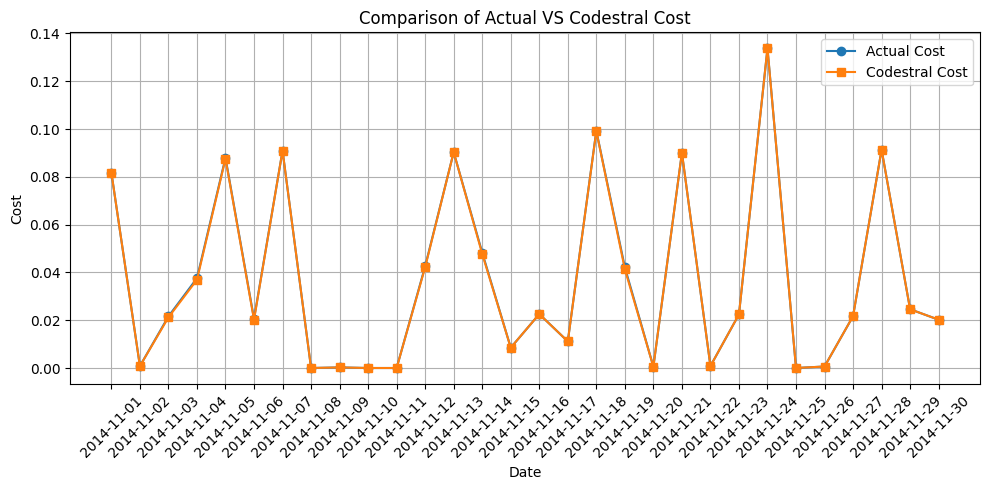

In [30]:
# Given dictionaries
#dict1 = {'2014-01-01': 0.9595631857213822, '2014-01-02': 0.9347714808920824, '2014-01-03': 1.0067462056031988, '2014-01-04': 0.9302405227936258, '2014-01-05': 0.9235501592712765}
#dict2 = {'2014-01-01': 0.9544651540929909, '2014-01-02': 0.9016743663752488, '2014-01-03': 0.950624147246825, '2014-01-04': 0.8997949478218772, '2014-01-05': 0.6745772700419963}

# Extract dates and values from dictionaries
dates1, values1 = zip(*sorted(actual_results.items()))
dates2, values2 = zip(*sorted(codestral_results.items()))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(dates1, values1, label='Actual Cost', marker='o')
plt.plot(dates2, values2, label='Codestral Cost', marker='s')
plt.title('Comparison of Actual VS Codestral Cost')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
!zip -r multiple_appliances_nov14.zip 'multiple_appliances'
# Download the zip file
from google.colab import files
files.download("/content/multiple_appliances_nov14.zip")

  adding: multiple_appliances/ (stored 0%)
  adding: multiple_appliances/multiple_appliances_2014-11-01.txt (deflated 71%)
  adding: multiple_appliances/multiple_appliances_2014-11-08.txt (deflated 70%)
  adding: multiple_appliances/multiple_appliances_2014-11-11.txt (deflated 71%)
  adding: multiple_appliances/multiple_appliances_2014-11-21.txt (deflated 75%)
  adding: multiple_appliances/multiple_appliances_2014-11-23.txt (deflated 73%)
  adding: multiple_appliances/multiple_appliances_2014-11-06.txt (deflated 65%)
  adding: multiple_appliances/multiple_appliances_2014-11-29.txt (deflated 69%)
  adding: multiple_appliances/multiple_appliances_2014-11-10.txt (deflated 70%)
  adding: multiple_appliances/multiple_appliances_2014-11-30.txt (deflated 67%)
  adding: multiple_appliances/multiple_appliances_2014-11-14.txt (deflated 71%)
  adding: multiple_appliances/multiple_appliances_2014-11-22.txt (deflated 69%)
  adding: multiple_appliances/multiple_appliances_2014-11-02.txt (deflated 67

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>